### Import

In [1]:
# Disable all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
from cephlib import ceph_phot, ceph_plot

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


### Load files

In [3]:
file = "data/jw01685-c1007_t003_nircam_clear-f150w_i2d.fits"
coord_tab = "data/Yuan_4258_2022_culled_good.csv"

photometry = ceph_phot(file, coord_tab, target="N4258", r=0.15)
crowd = True


In [ ]:
photometry.image_plot_stars(plot_aper=False)

In [ ]:
photometry.zoom_images_all(25)

In [35]:
photometry.get_psf()


In [ ]:
photometry.plot_psf(True)

In [ ]:
photometry.test_crowding_empty()

In [ ]:
photometry.test_crowding_single()

In [6]:
photometry.do_photometry(ap_size=25, do_crowd=crowd, verbose=False)

  0%|          | 0/78 [00:00<?, ?stars/s]

dev.mean() = 7.137682941351884, dev.std() = 13.32849230939838, sc_dev.mean() = 4.32429360602473, sc_dev.std() = 4.277916817267508, b = 2.4842526815248593, b_err = 0.1405641505847696
dev.mean() = 6.519009760598762, dev.std() = 11.217488826801143, sc_dev.mean() = 3.5267656138565875, sc_dev.std() = 3.6409932235382754, b = 1.6417637856162526, b_err = 0.09967973703730602
dev.mean() = 0.990464597581771, dev.std() = 1.4312112605717433, sc_dev.mean() = 0.7497348333405516, sc_dev.std() = 0.444470038449805, b = 0.718419569277871, b_err = 0.029497030381271296
dev.mean() = 5.0546897009640555, dev.std() = 6.516390299124529, sc_dev.mean() = 3.688588566689911, sc_dev.std() = 2.9377069000439167, b = 2.946047425249908, b_err = 0.18876984818239811
dev.mean() = 5.397712248352293, dev.std() = 7.269078837623341, sc_dev.mean() = 3.5084625332051744, sc_dev.std() = 3.3946148999152914, b = 1.7192164070814426, b_err = 0.14099413337392053
dev.mean() = 11.456347287733871, dev.std() = 28.551700132775352, sc_dev.me

In [17]:
op = photometry.results()
print(op)


jw01685-c1007_t003_nircam_clear-f150w_i2d_out.xlsx


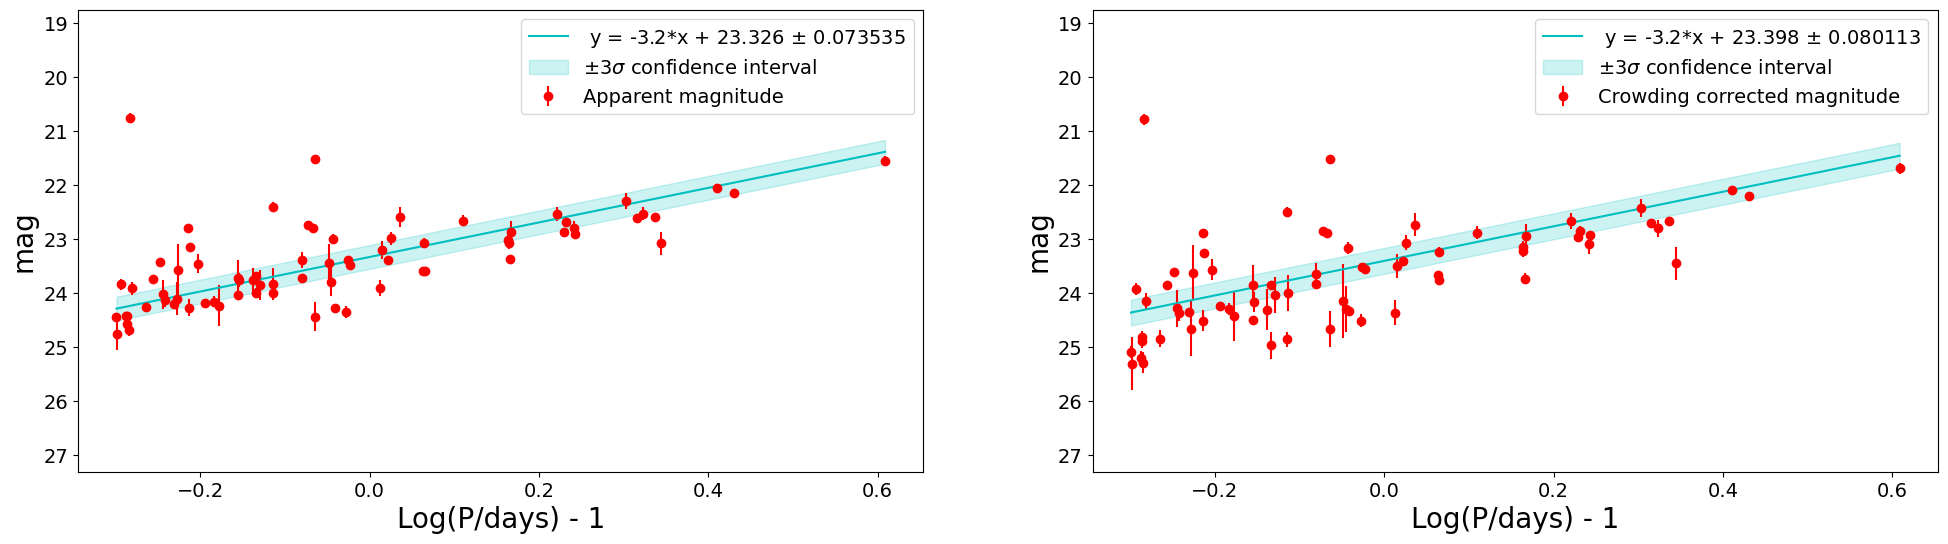

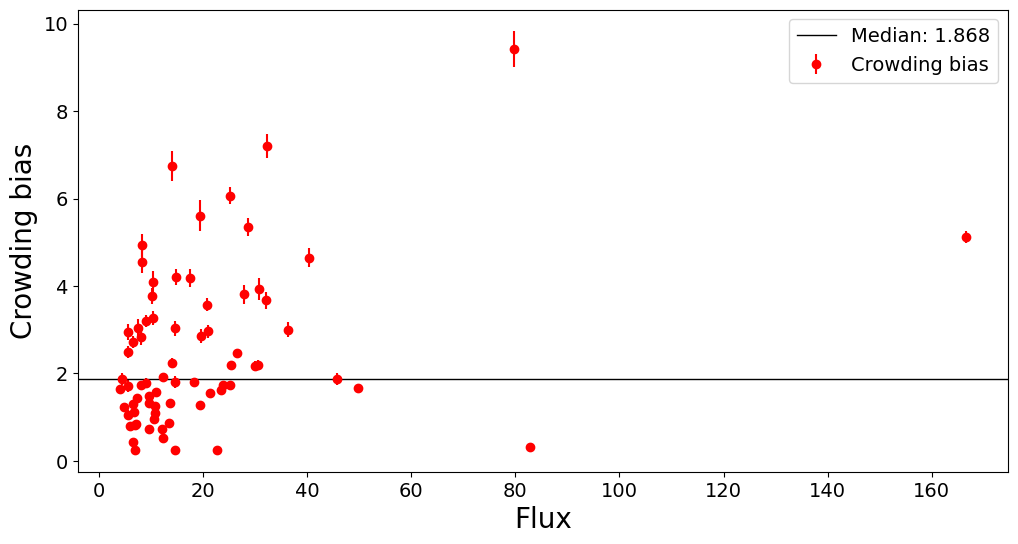

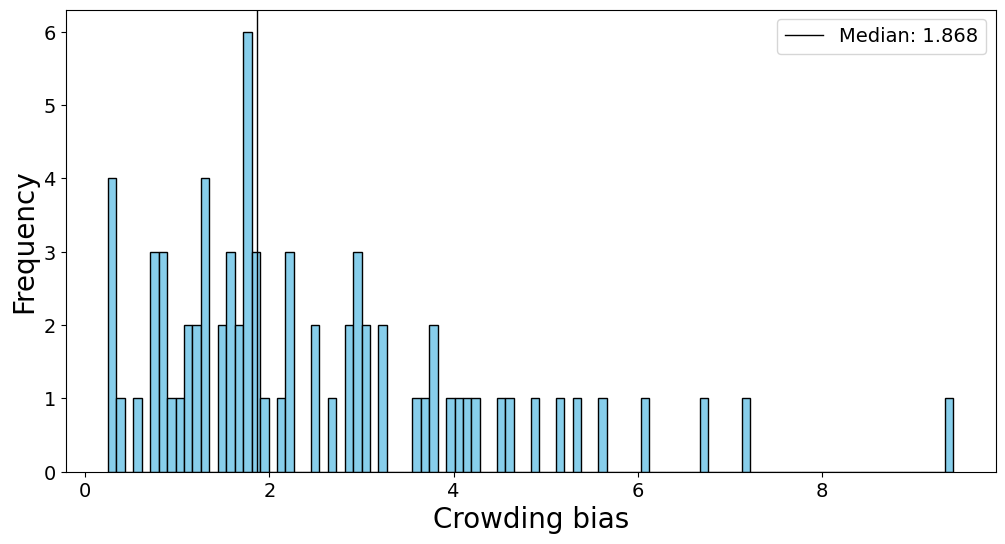

In [4]:
plots = ceph_plot(file, "jw01685-c1007_t003_nircam_clear-f150w_i2d_out.xlsx", plot_crowd=crowd)

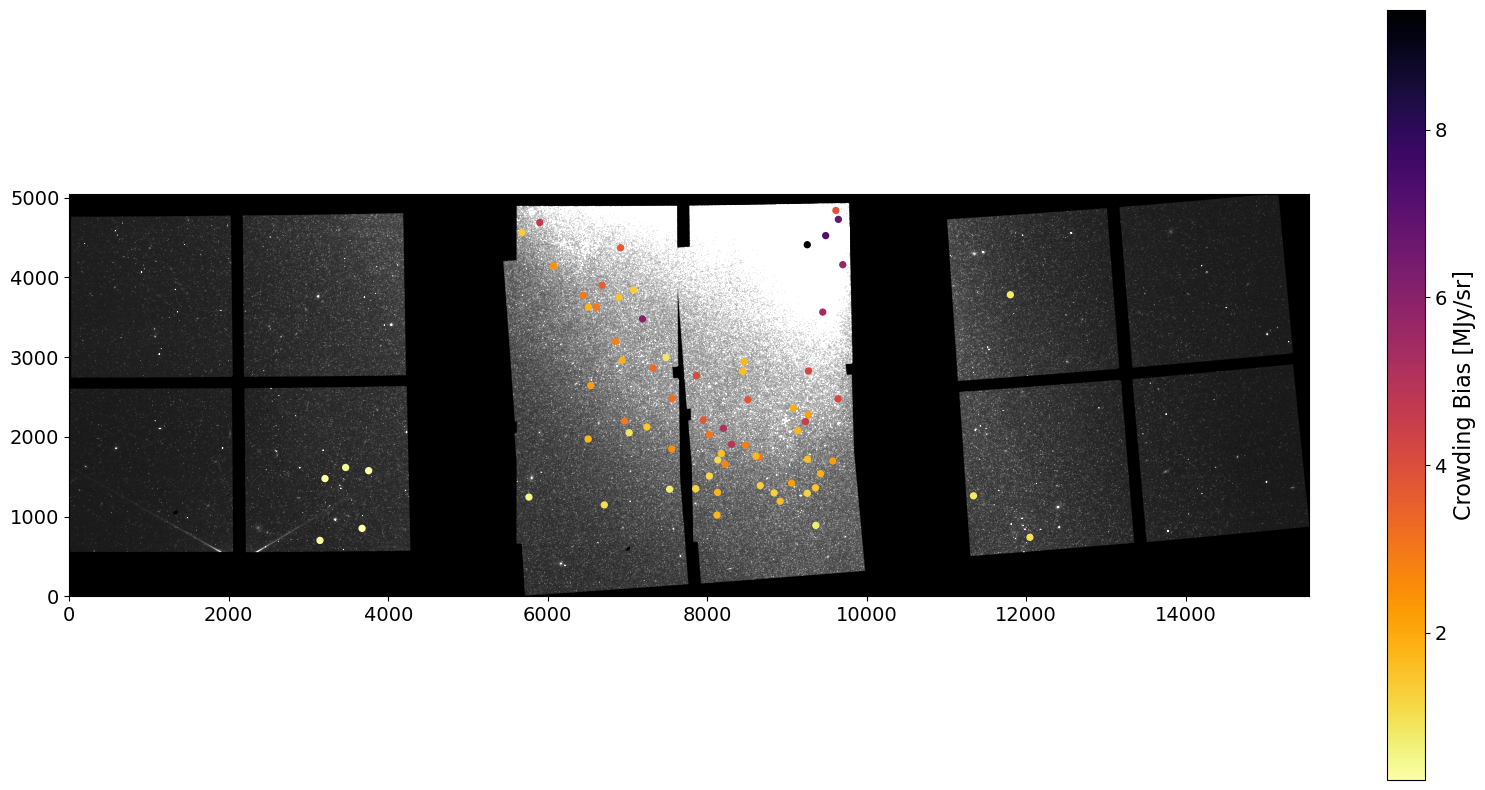

In [5]:
x = plots.table["ra_pix"]
y = plots.table["dec_pix"]
z = plots.table["b"]
s = plots.table["ID"]
d = 5
x_d = x - d
y_d = y - d

import matplotlib.pyplot as plt
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(photometry.data, cmap='gray', origin='lower',vmin=0.01, vmax=2)
im = ax.scatter(x, y, s=18, c=z, cmap='inferno_r')
plt.colorbar(im, ax=ax).set_label("Crowding Bias [MJy/sr]")
# for i,j,k in zip(x_d, y_d, s):
    # ax.text(i, j, str(k), fontsize=9)
plt.show()


In [ ]:
photometry.pix_apertures.positions

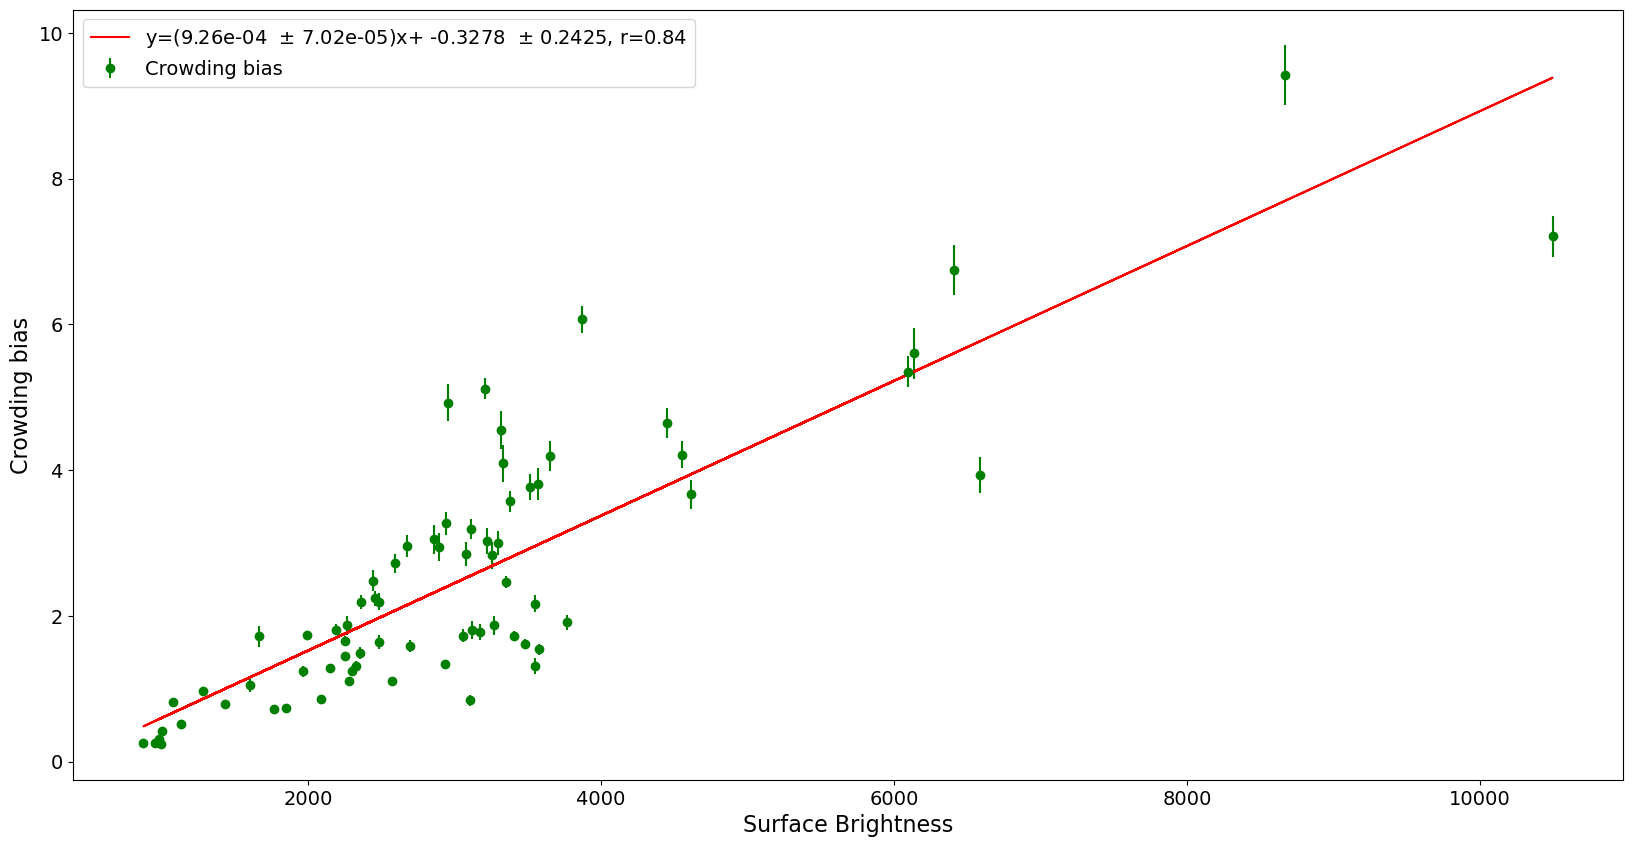

In [6]:
x = plots.table["surface_brightness"]
y = plots.table["b"]
y_e = plots.table["b_e"]
import numpy as np
fig, ax = plt.subplots(figsize=(20, 10))
ax.errorbar(x, y, yerr=y_e, fmt= 'go', label='Crowding bias')
plt.xlabel("Surface Brightness")
plt.ylabel("Crowding bias")
#linear fit
p, cov = np.polyfit(x, y, 1, cov=True)
m, b = p
me, be = np.sqrt(np.diag(cov))
#pearson correlation
r = np.corrcoef(x, y)[0, 1]
plt.plot(x, m*x + b, 'r-', label=rf'y=({m:.2e}  $\pm$ {me:.2e})x+ {b:.4f}  $\pm$ {be:.4f}, r={r:.2f}')
plt.legend()
plt.show()

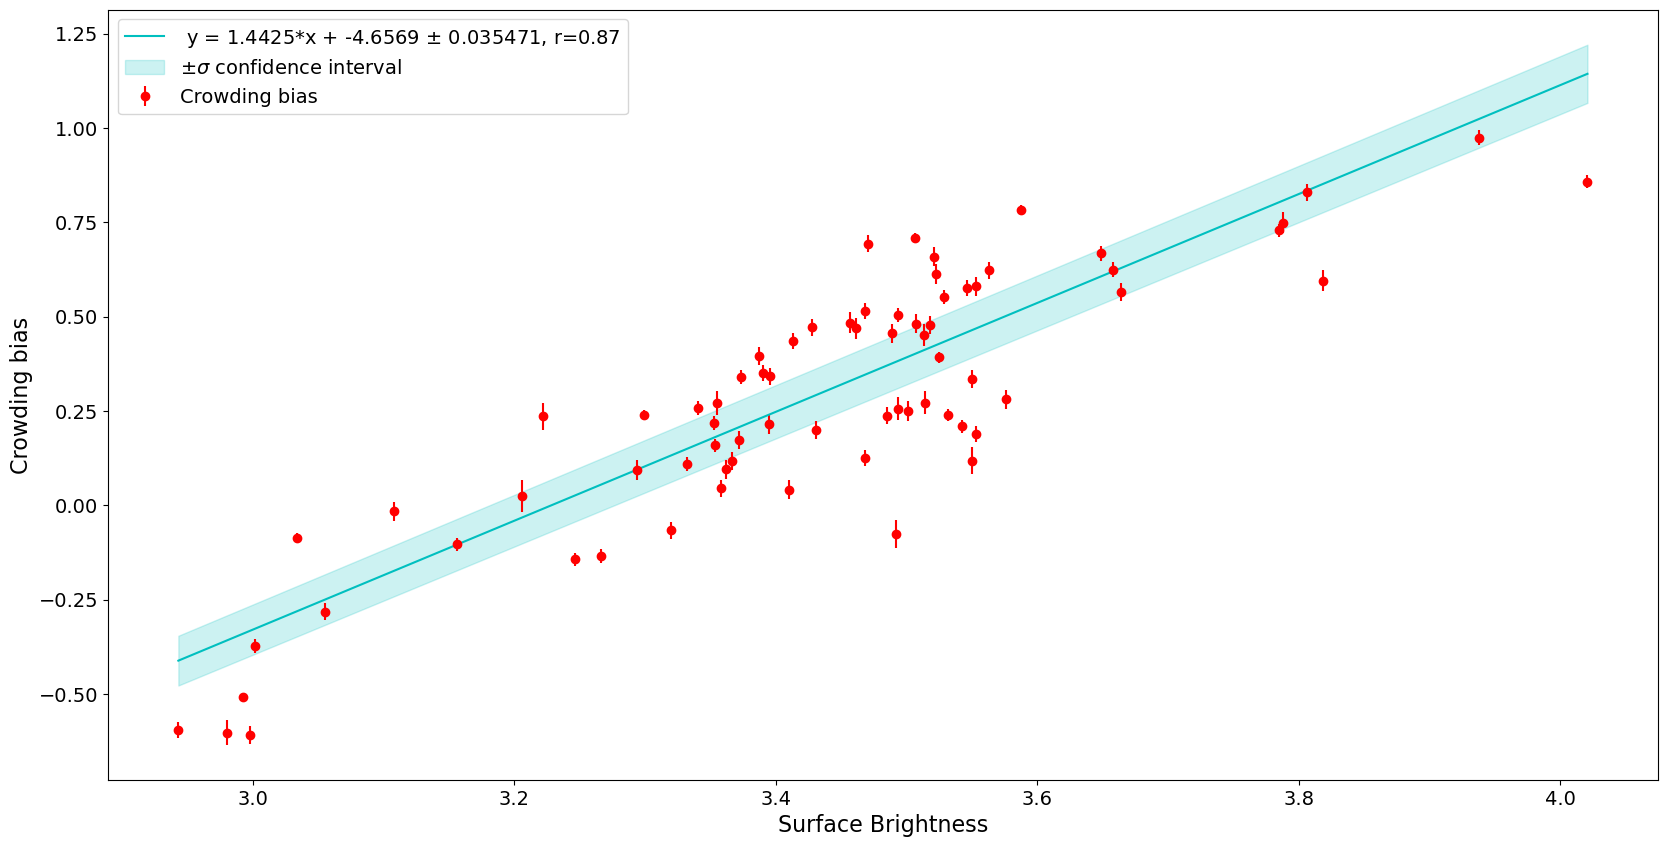

In [7]:
from scipy.optimize import curve_fit
x = np.log10(plots.table["surface_brightness"])
y = np.log10(plots.table["b"])
y_e = plots.table["b_e"]/(np.log(10)*plots.table["b"])
fig, ax = plt.subplots(figsize=(20, 10))
ax.errorbar(x, y, yerr=y_e, fmt='ro', label='Crowding bias')
plt.xlabel("Surface Brightness")
plt.ylabel("Crowding bias")
#linear fit
# dat = pd.DataFrame({"x": x, "y": y, "y_err": y_err})
# dat = dat.dropna()
def linear(x, m, c):
    return m*x + c
opt, cov = curve_fit(linear,x,y, sigma=y_e, absolute_sigma=True, check_finite=False, nan_policy="omit")
m, c = opt
m_err, c_err = np.sqrt(np.diag(cov))
#pearson correlation
r = np.corrcoef(x, y)[0, 1]

xf = np.array([min(x), max(x)])
yf = m*xf + c
yf_up = (m+m_err)*xf +c +c_err
yf_down = (m-m_err)*xf +c -c_err
plt.plot(xf, yf, "c-", label=f" y = {m:.5g}*x + {c:.5g} $\pm$ {c_err:.5g}, r={r:.2f}")
plt.fill_between(xf, yf_up, yf_down, color="c", alpha=0.2, label = "$\pm \sigma$ confidence interval")
plt.legend()
plt.show()

  0%|          | 0/78 [00:00<?, ?it/s]

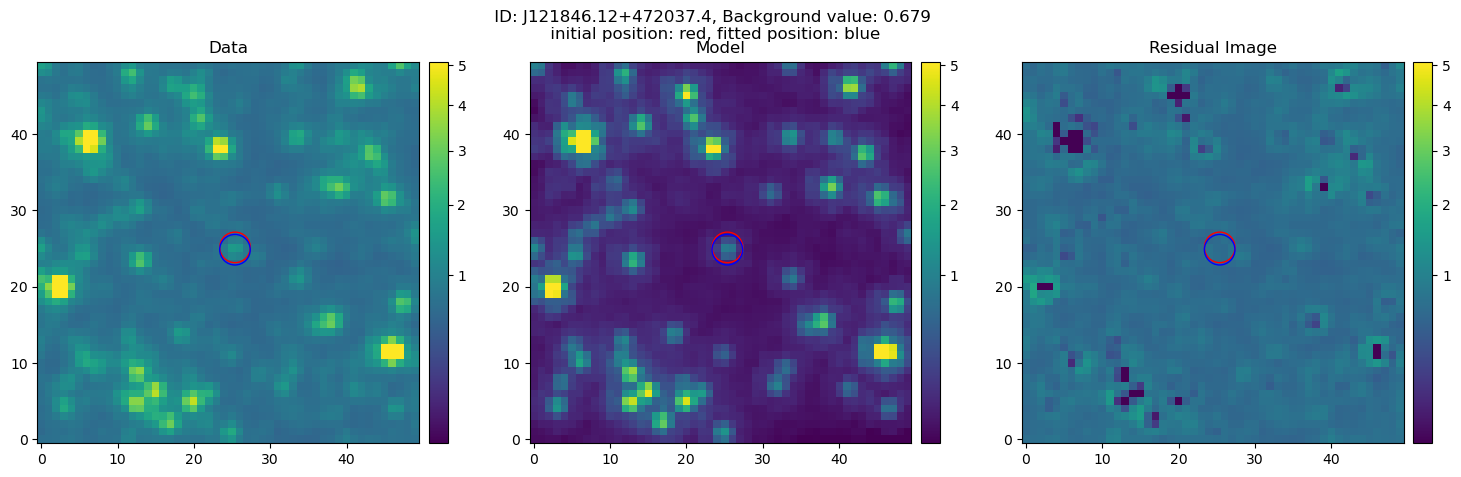

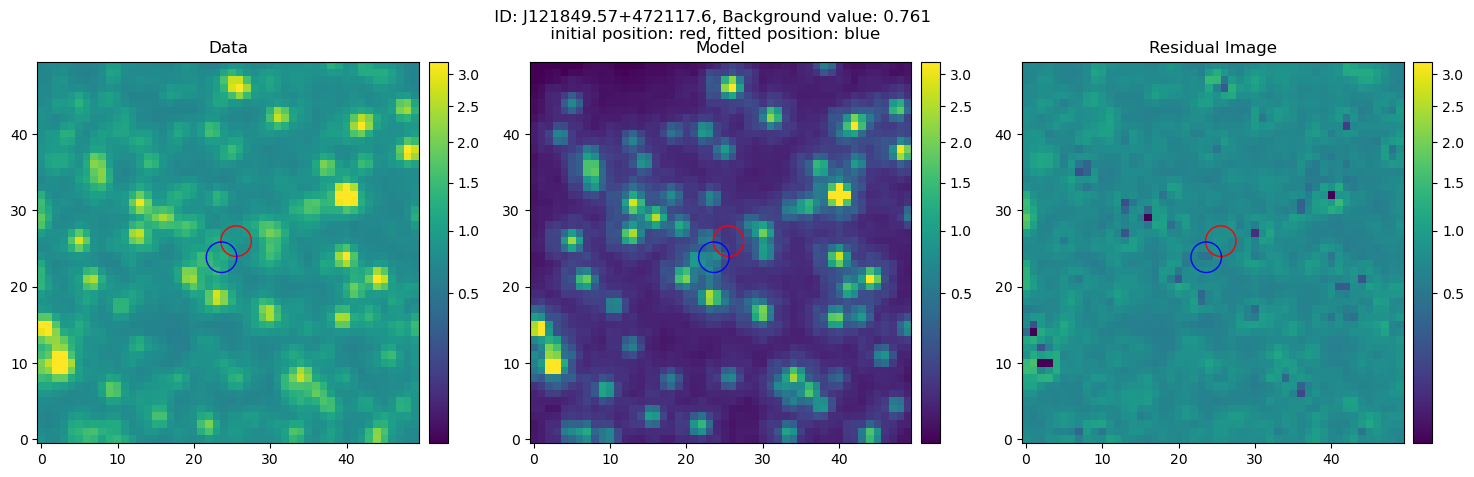

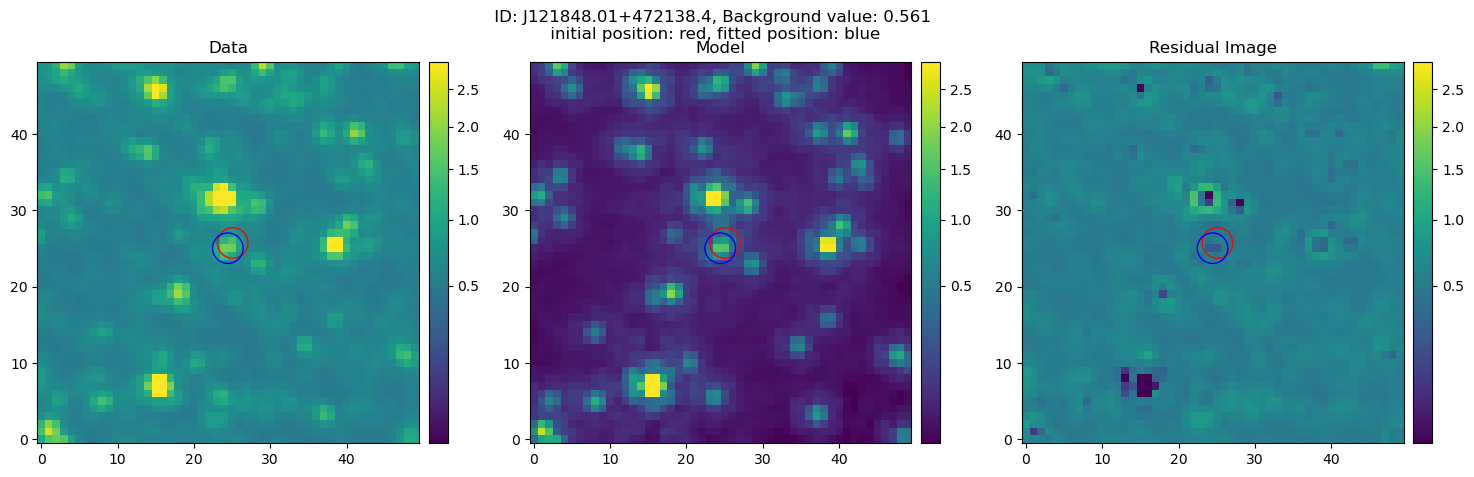

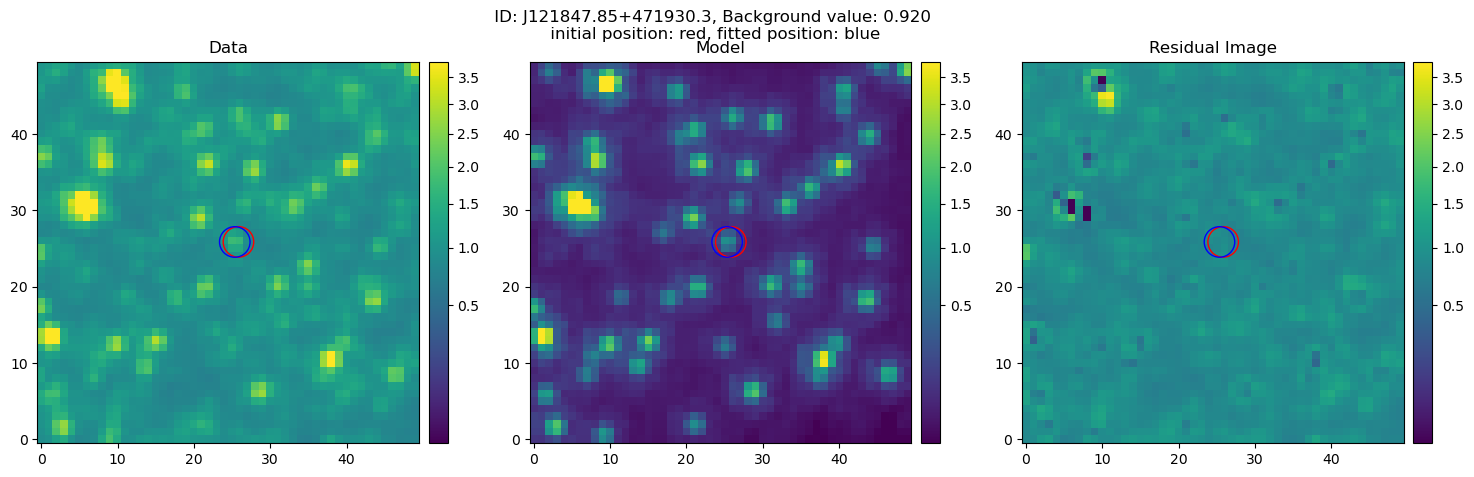

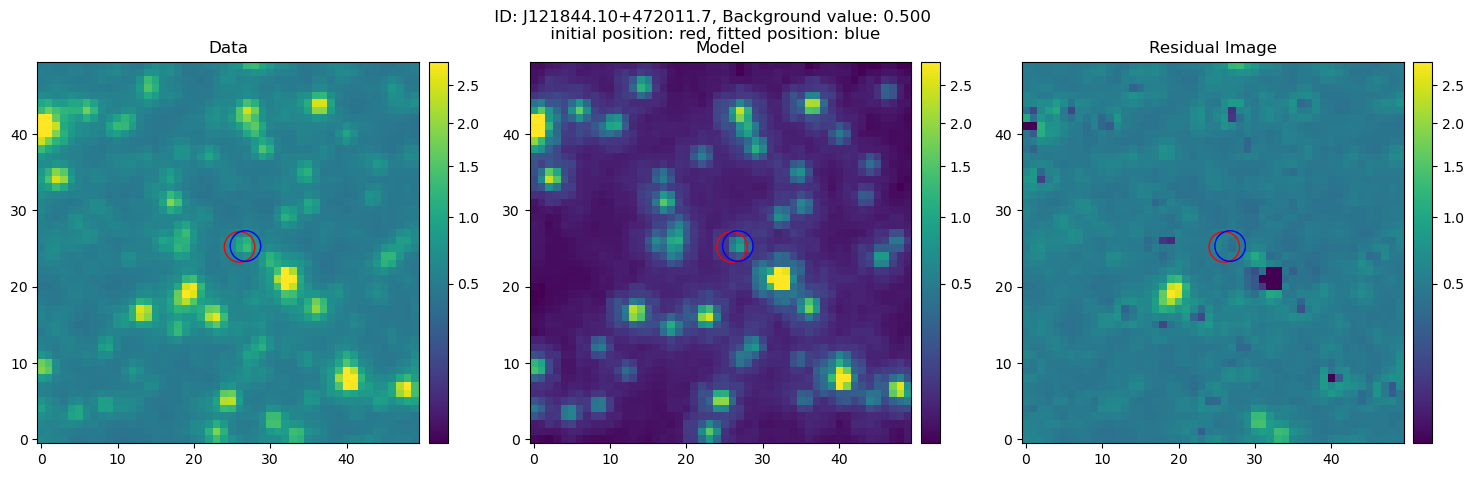

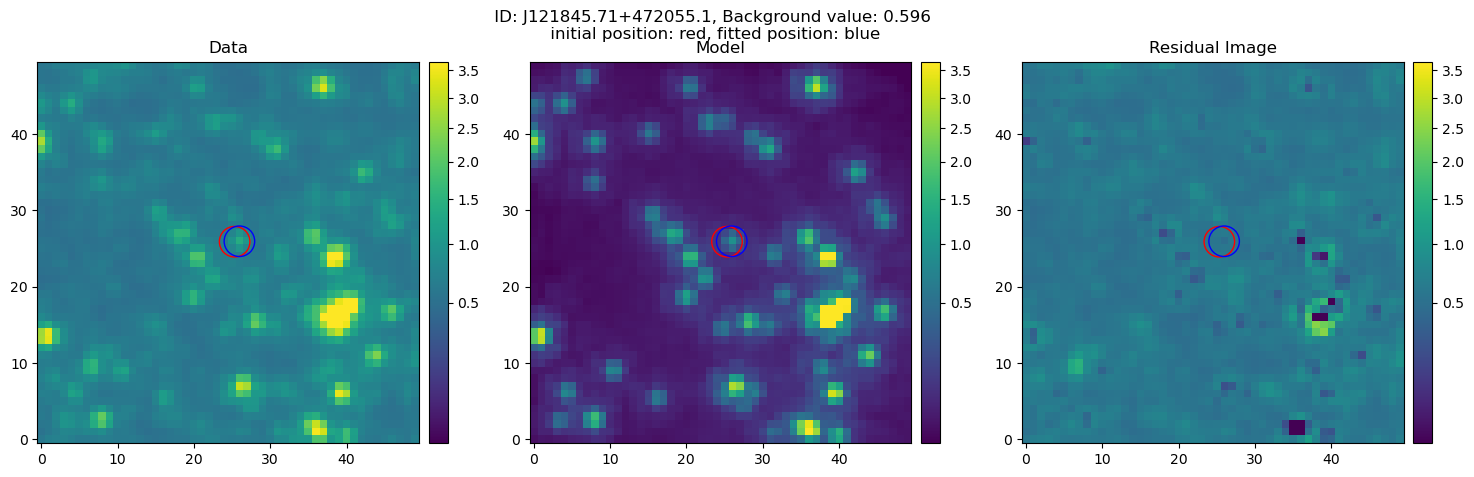

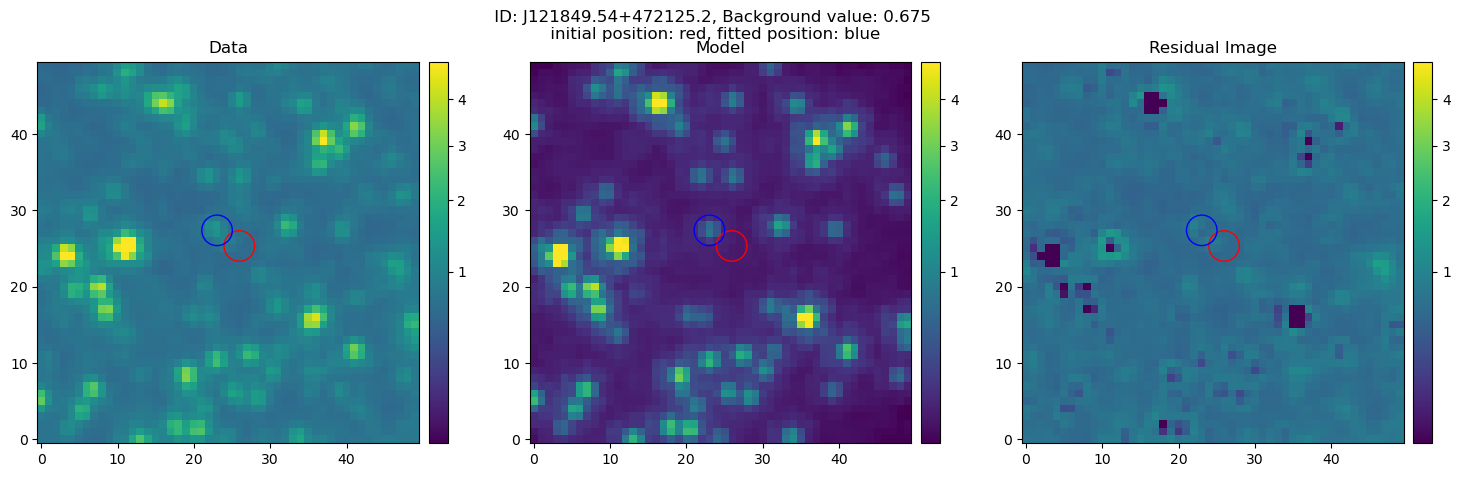

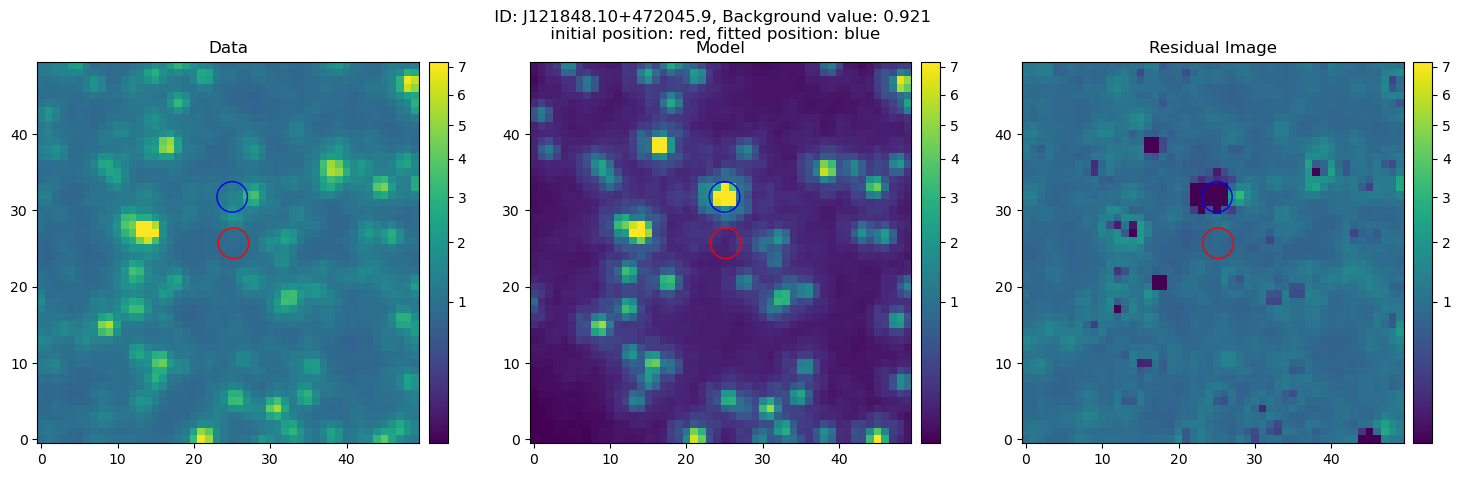

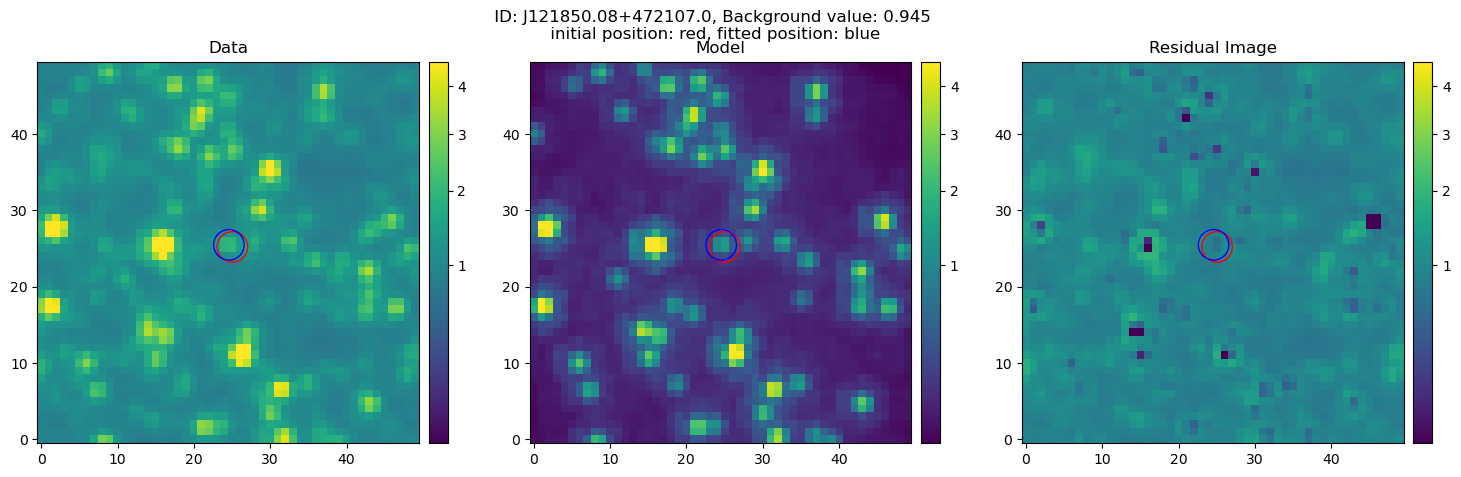

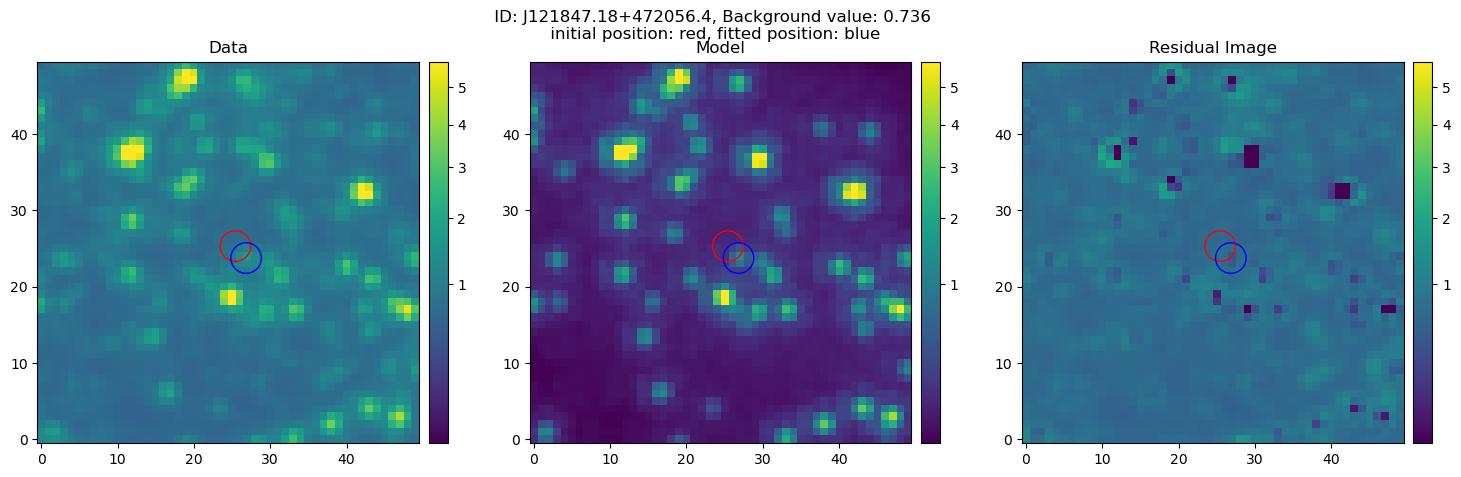

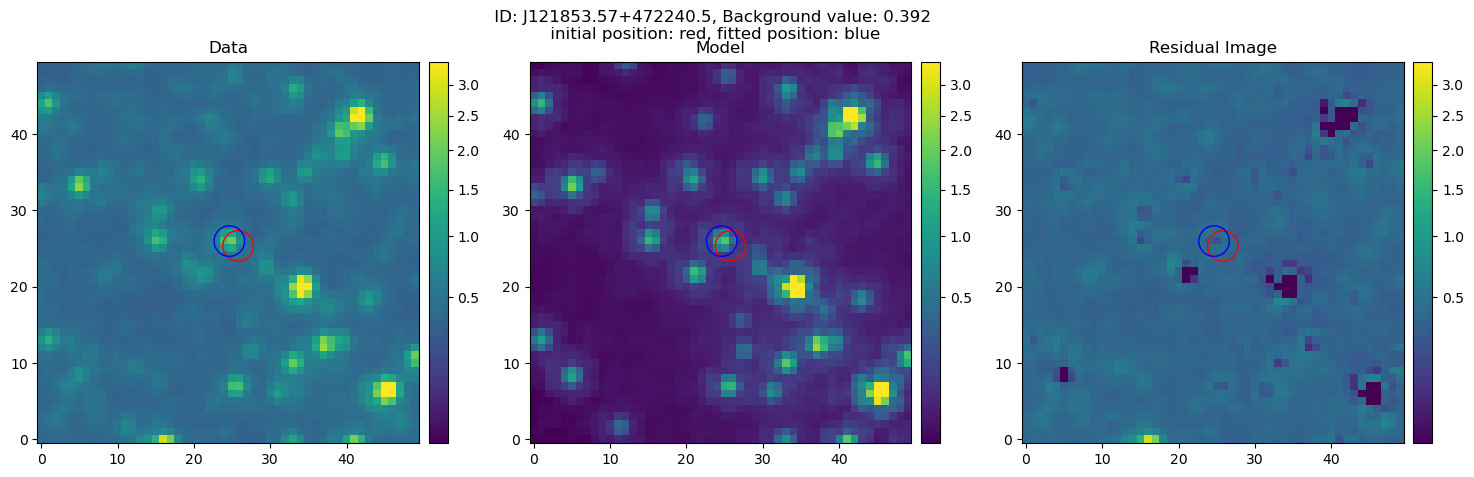

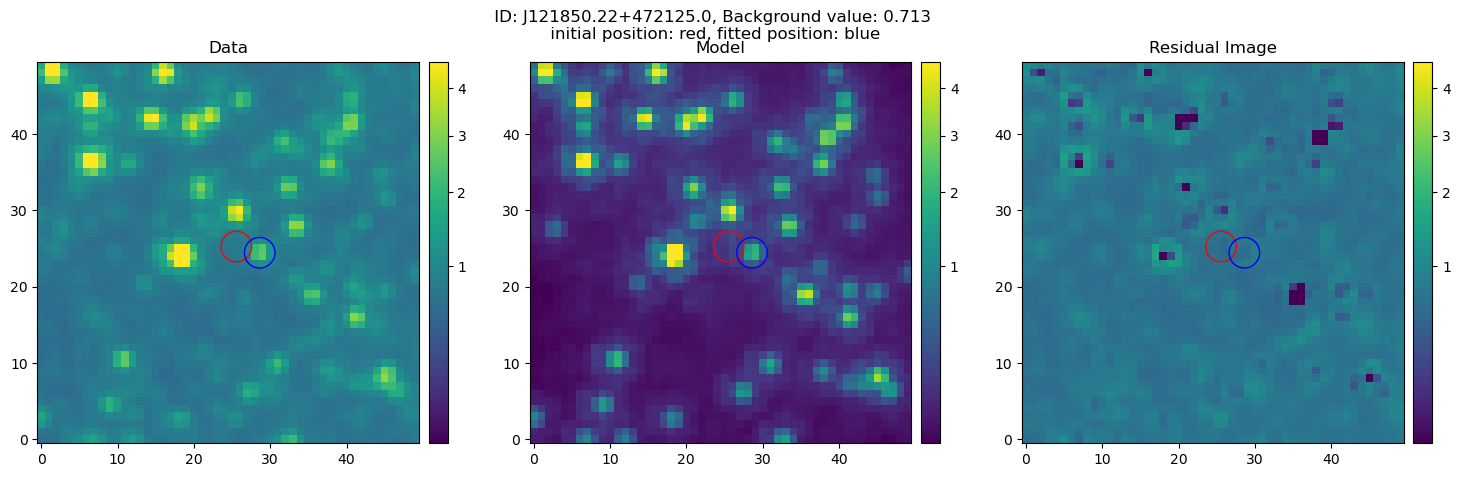

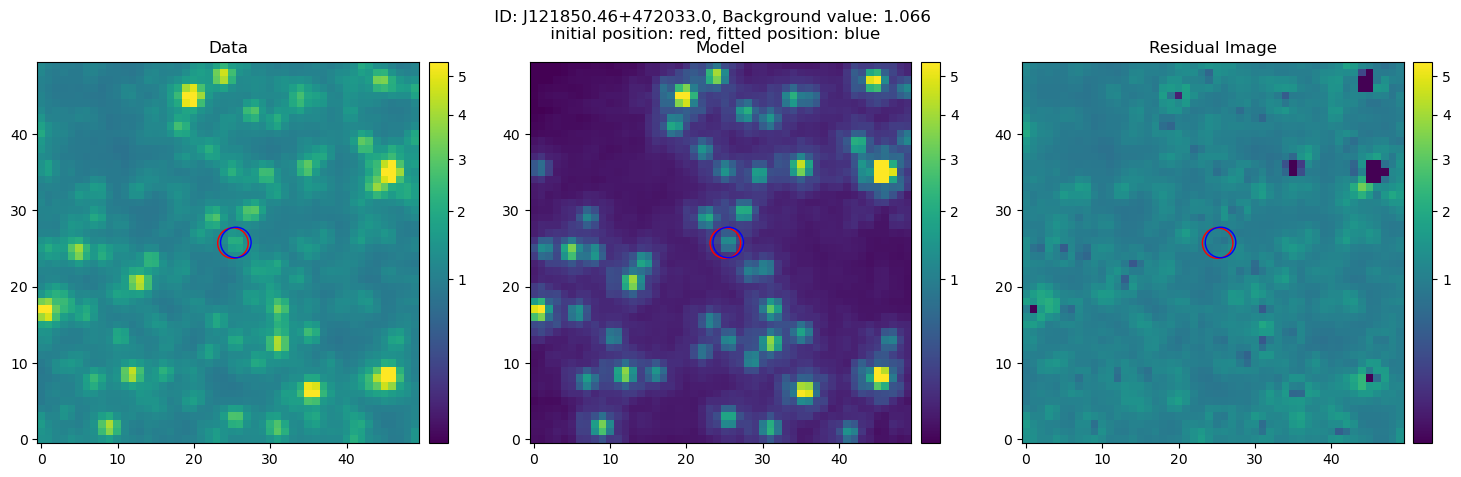

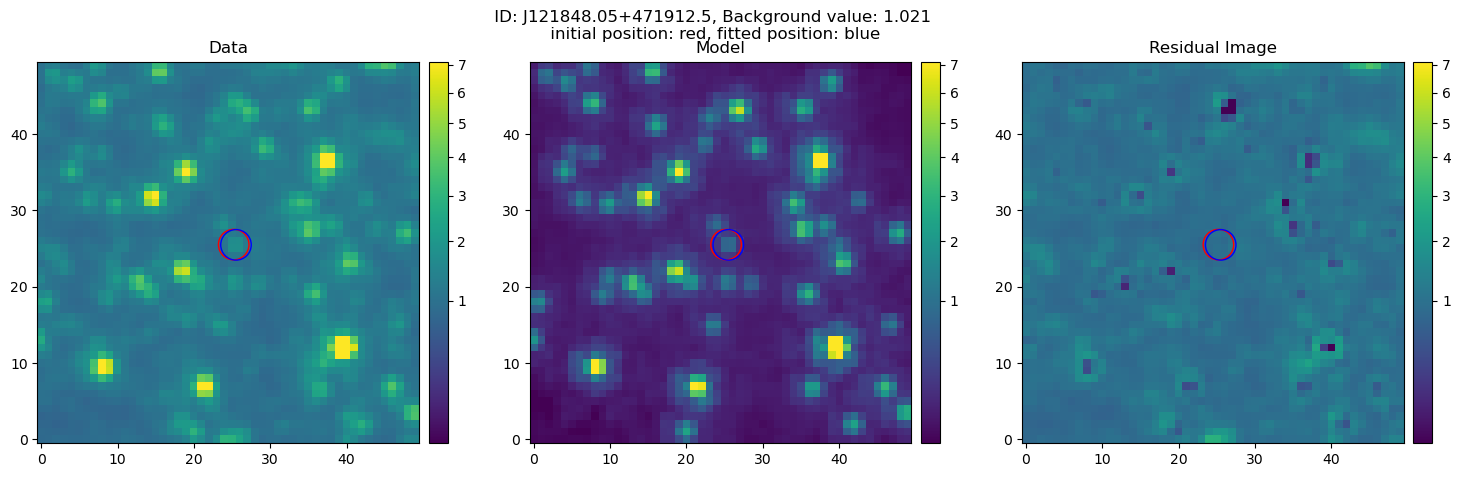

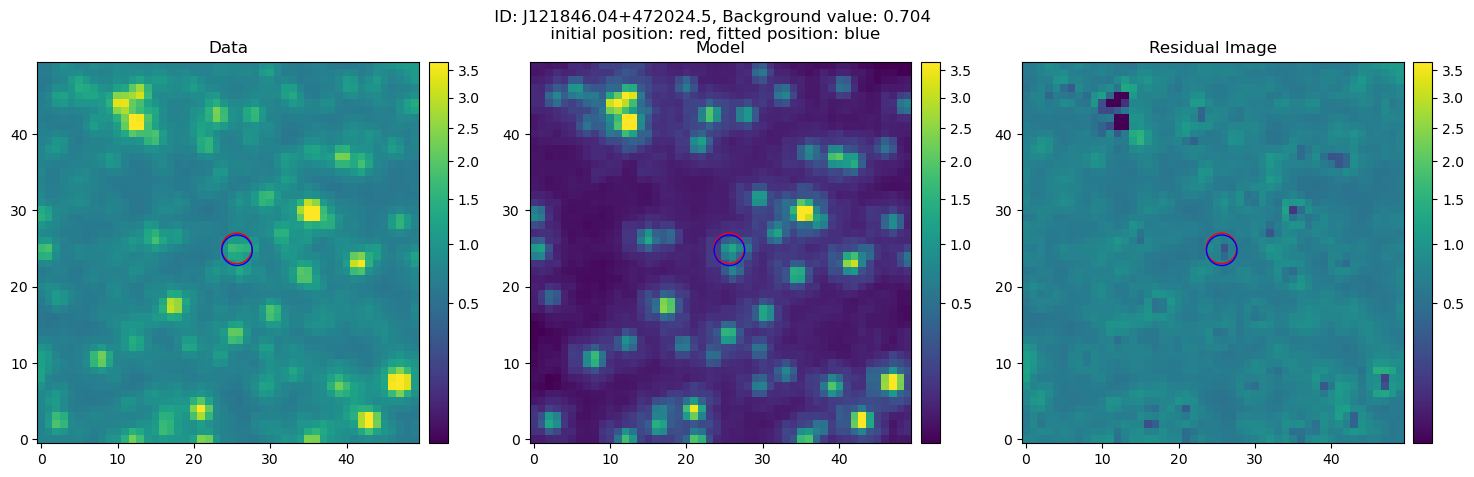

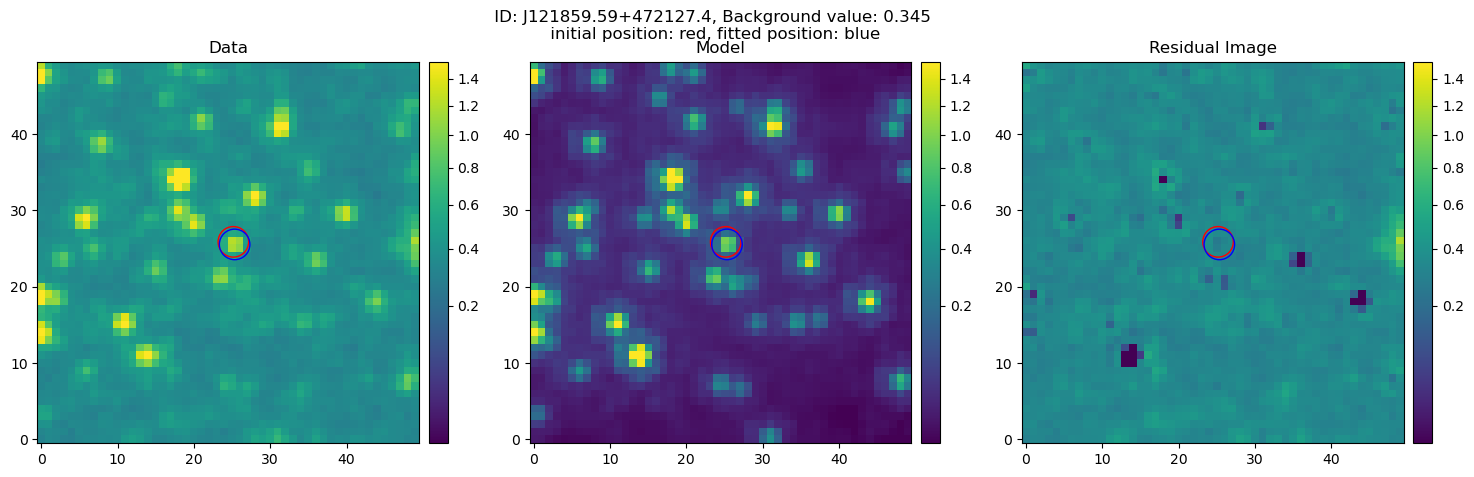

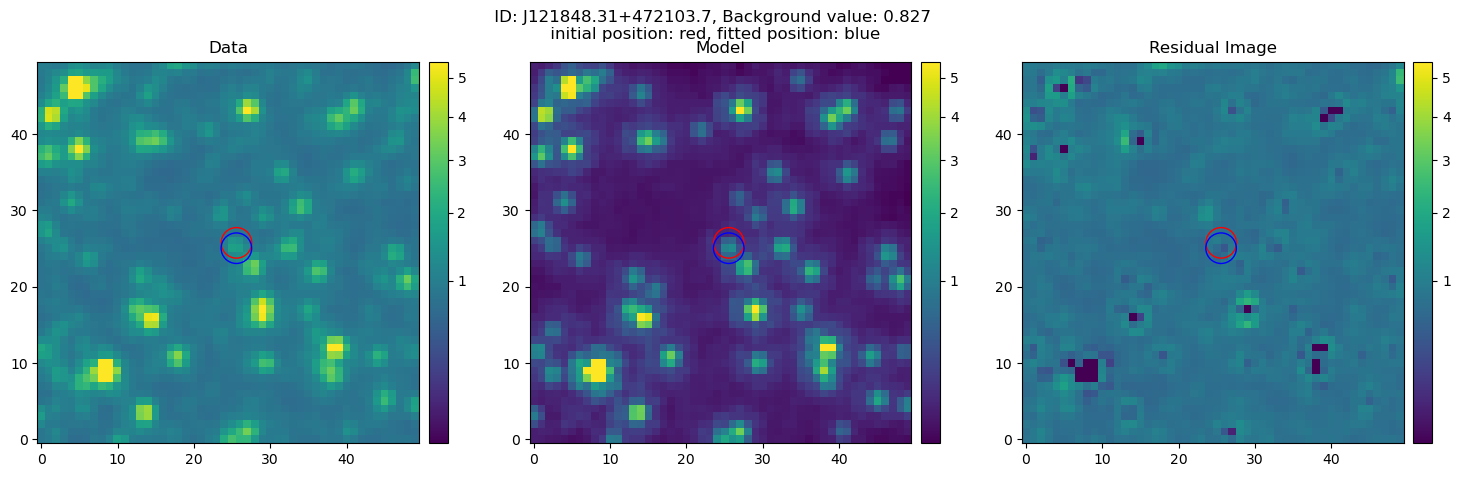

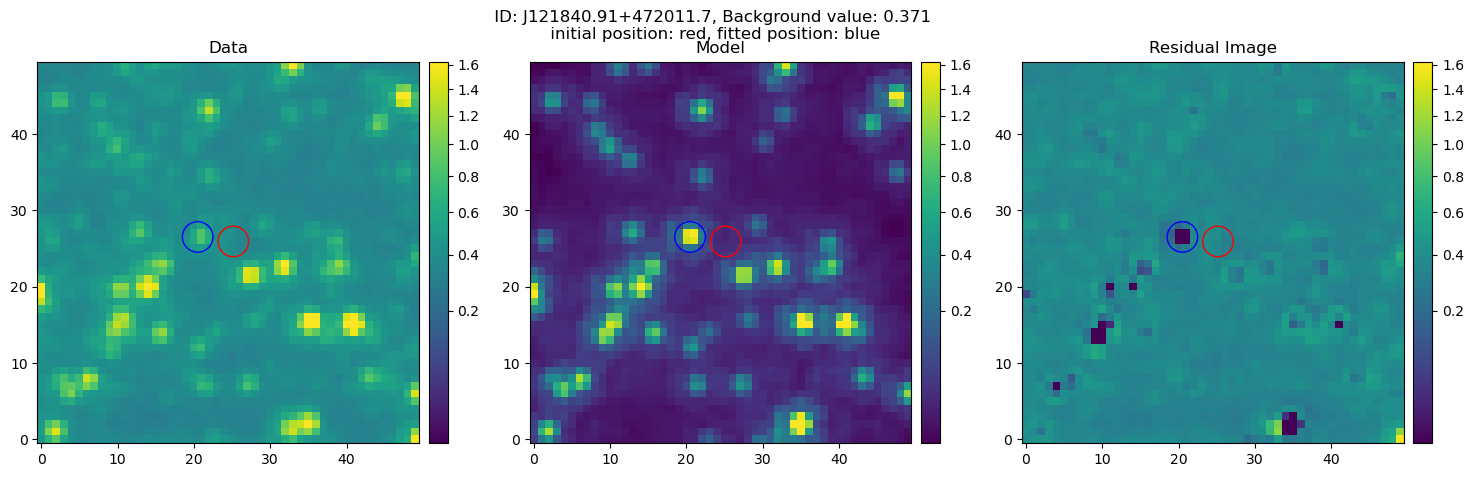

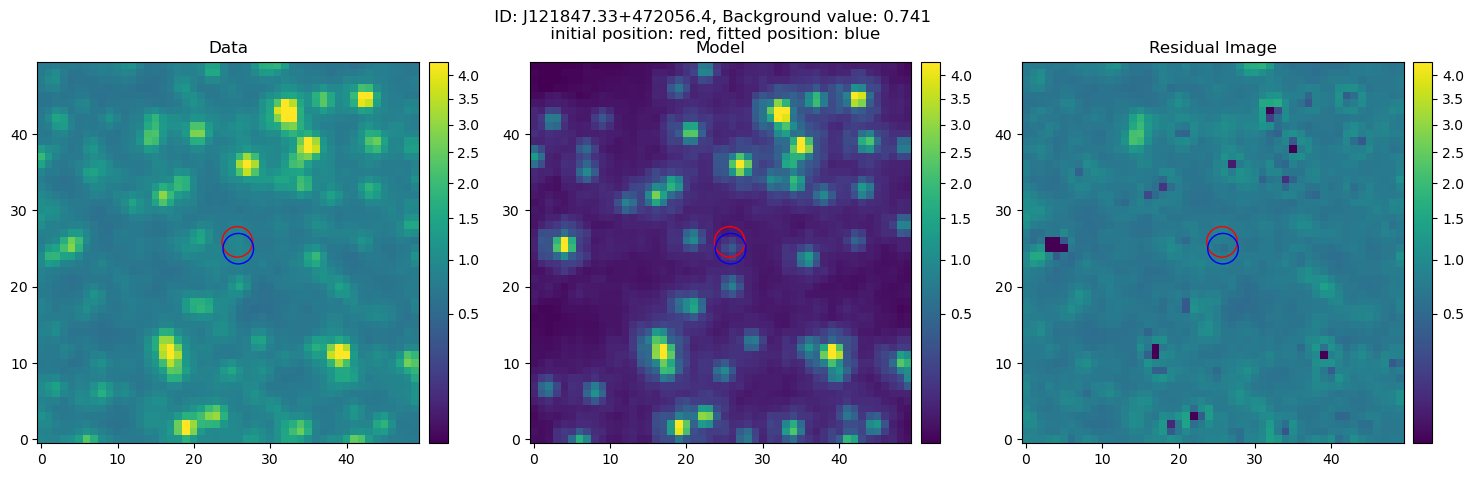

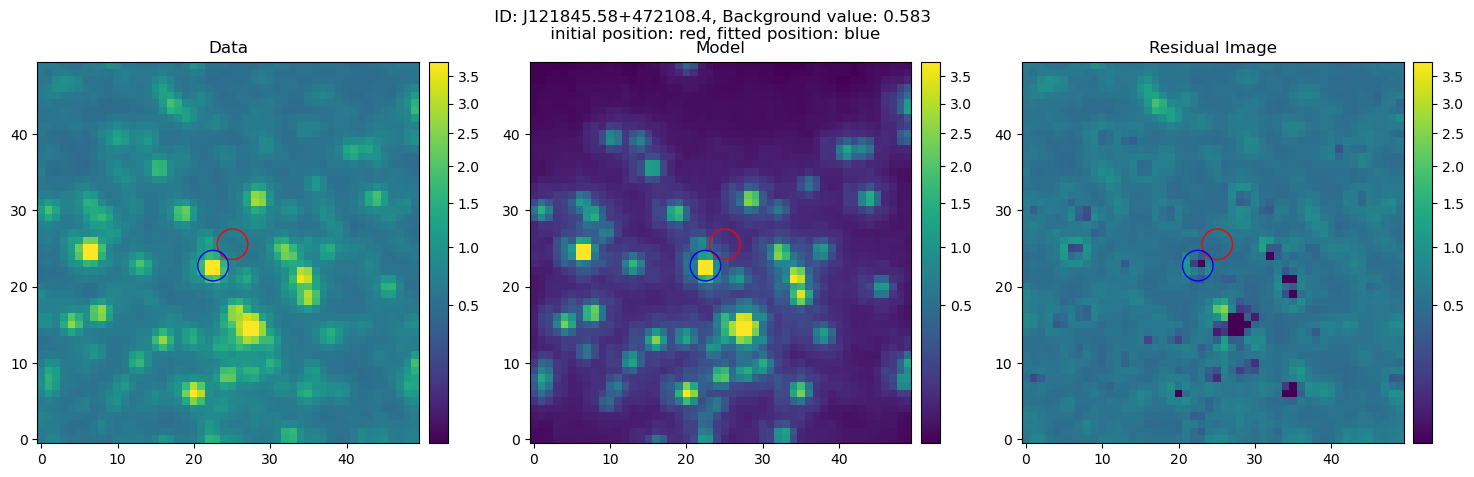

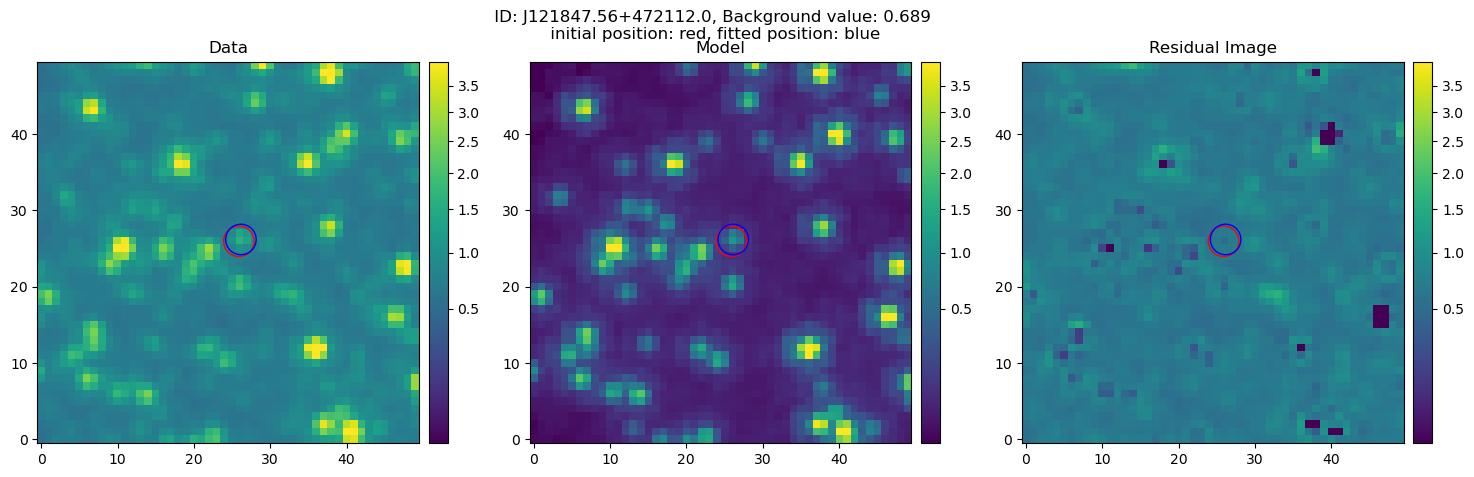

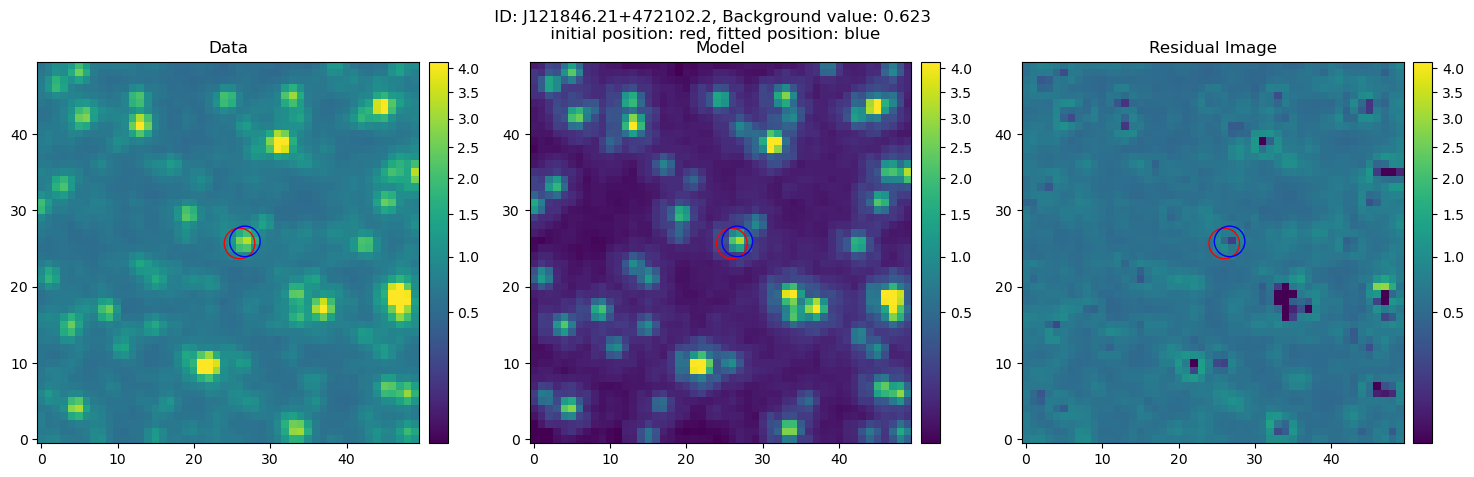

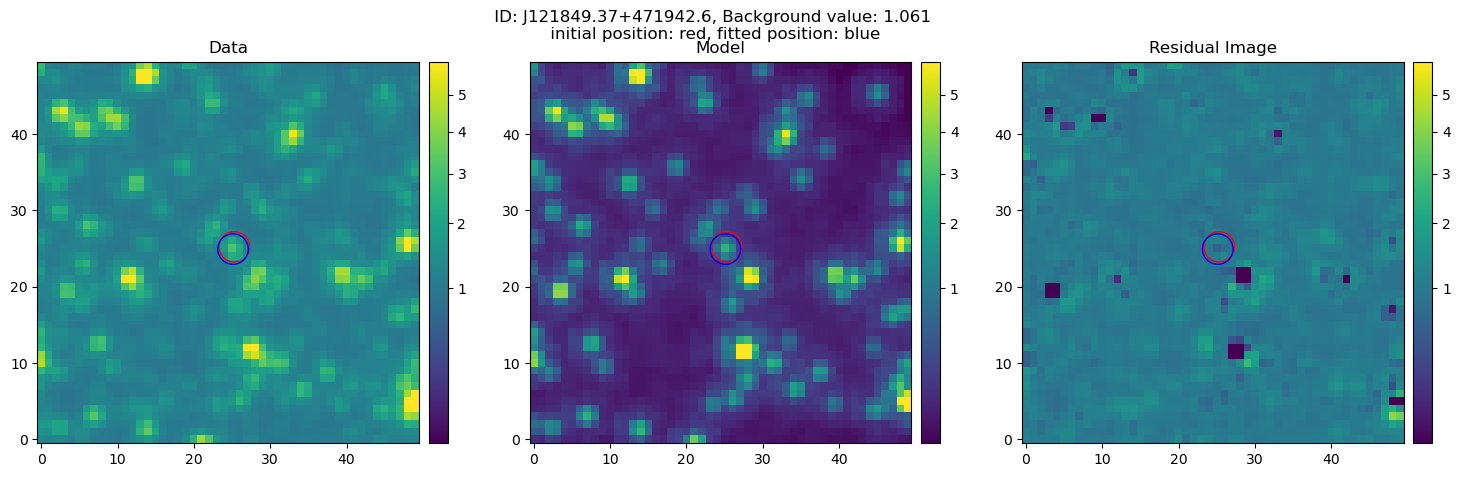

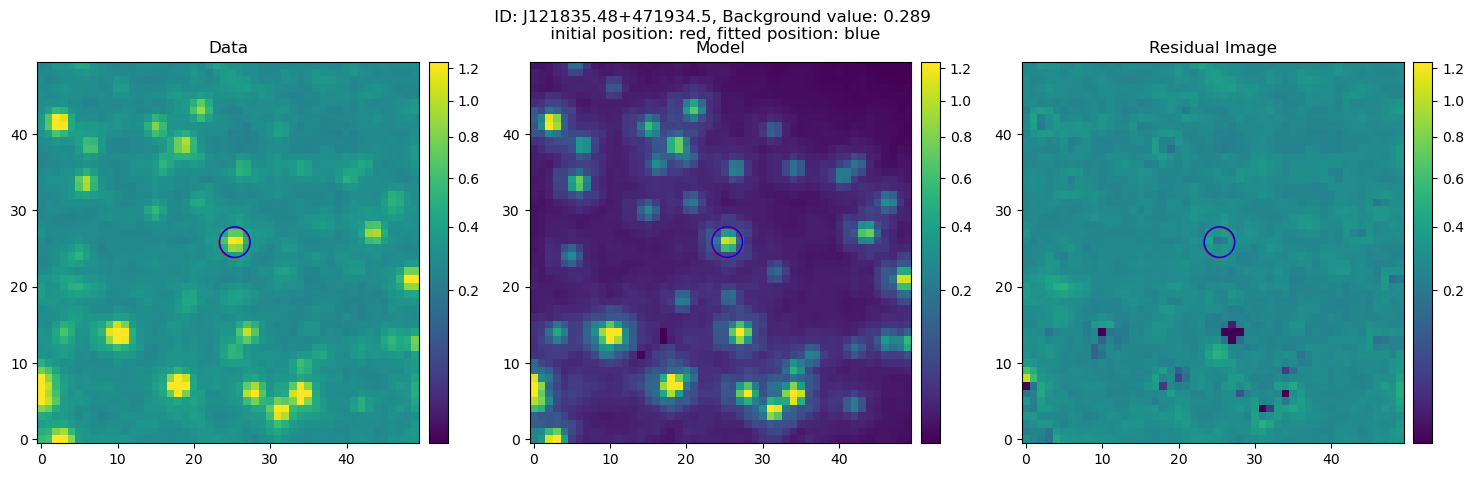

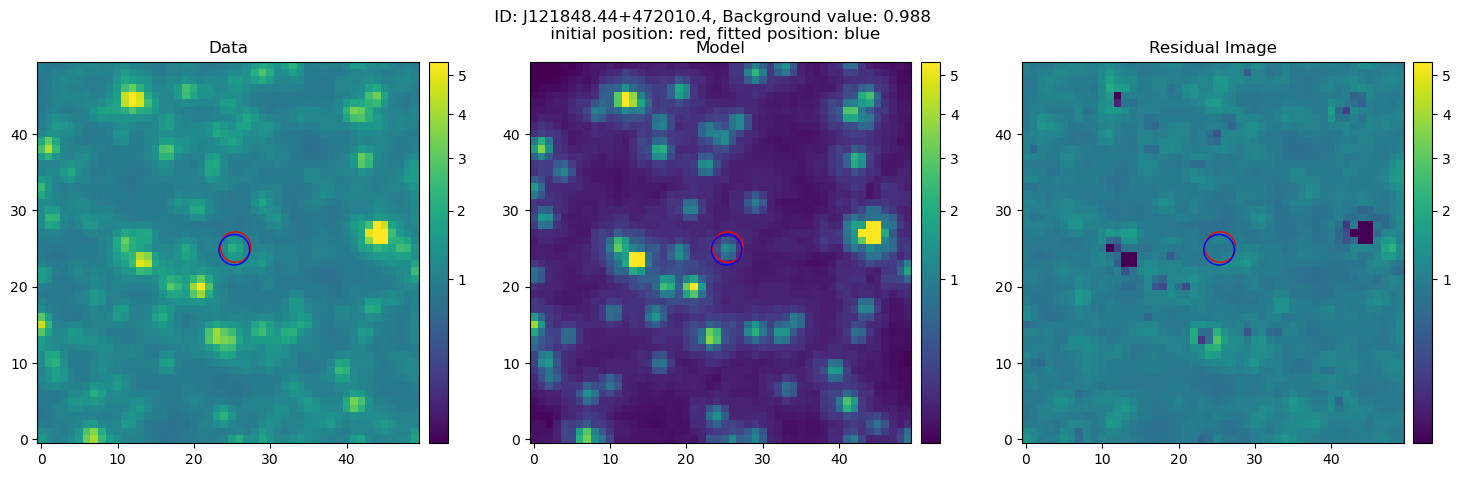

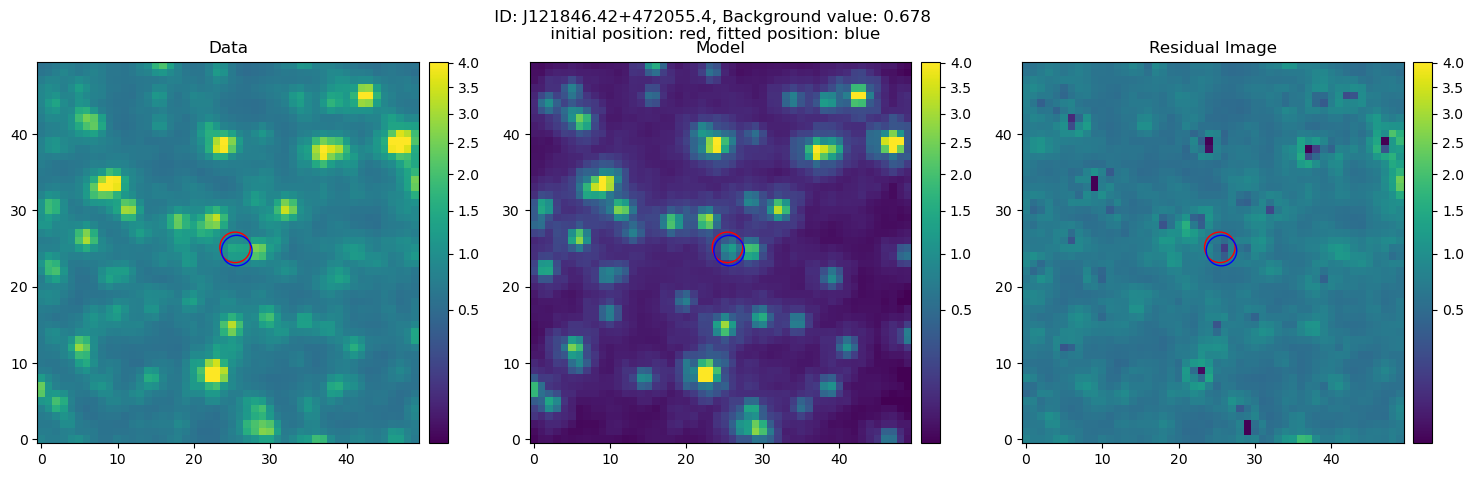

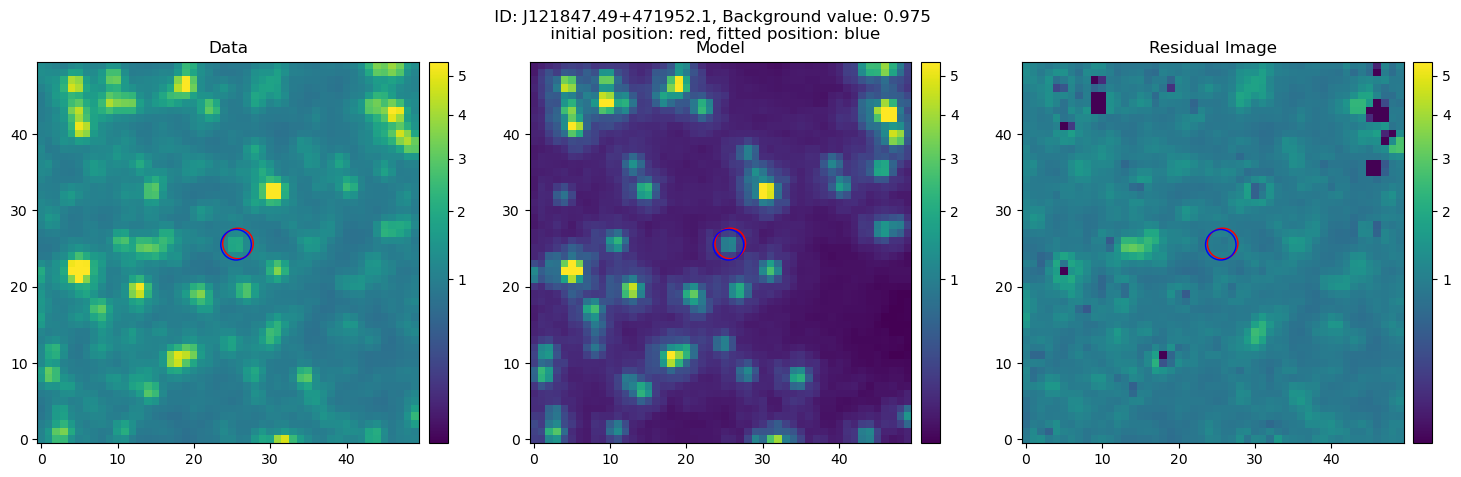

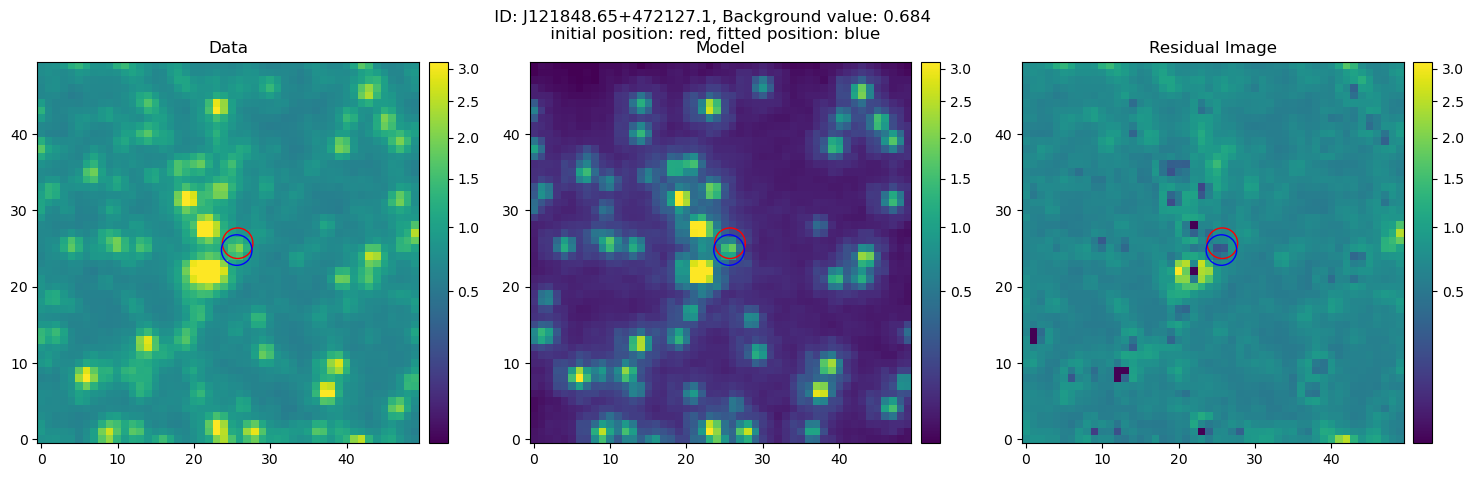

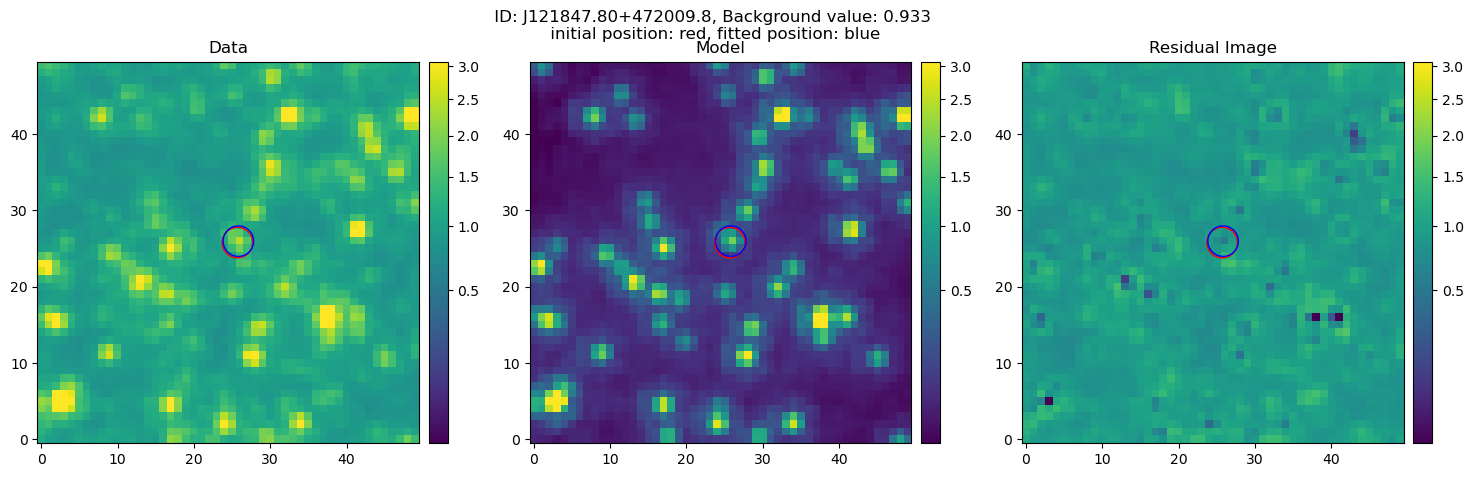

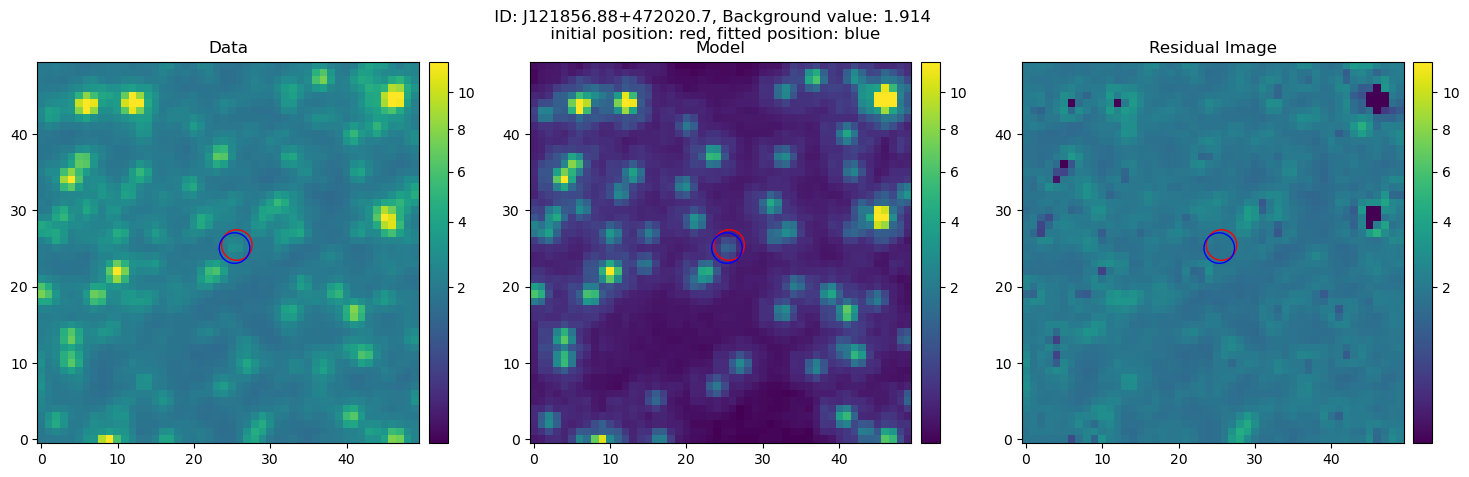

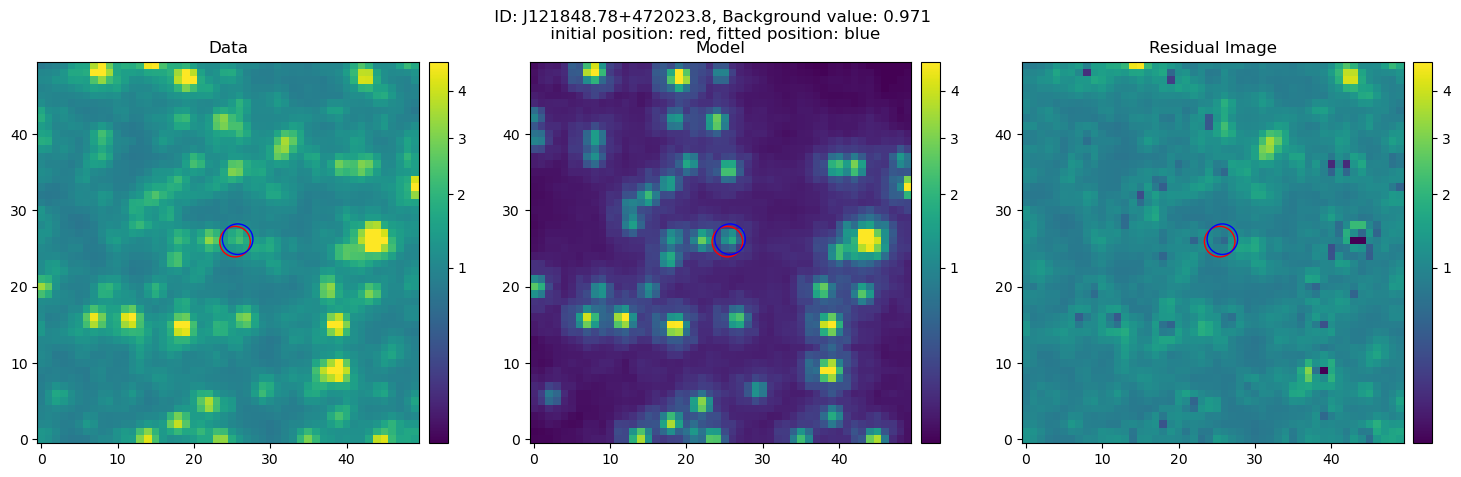

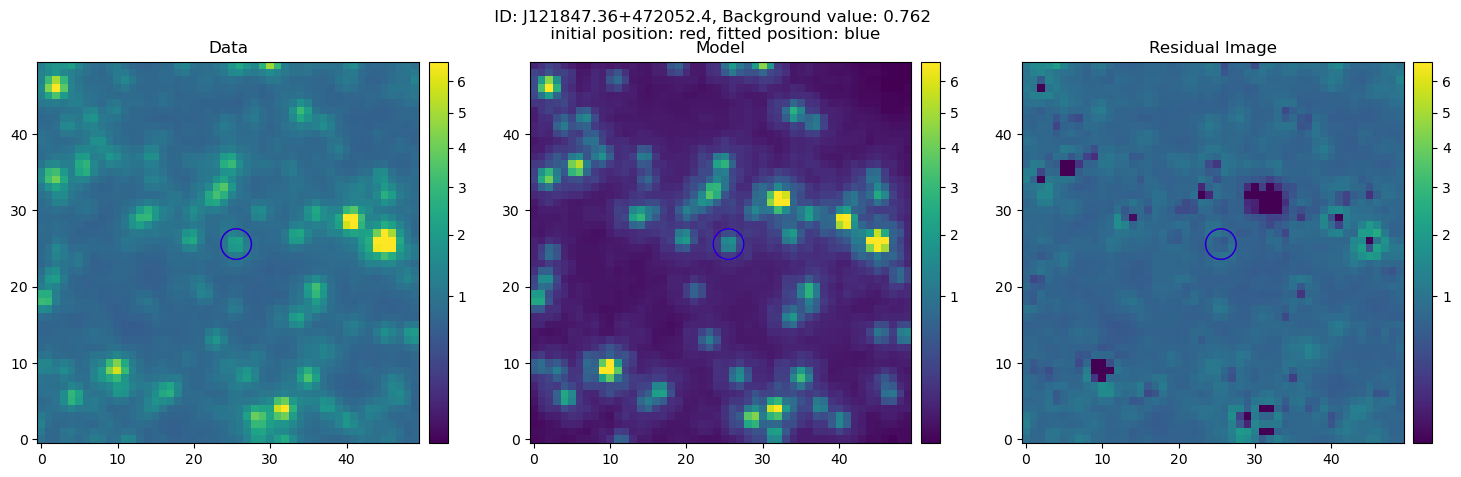

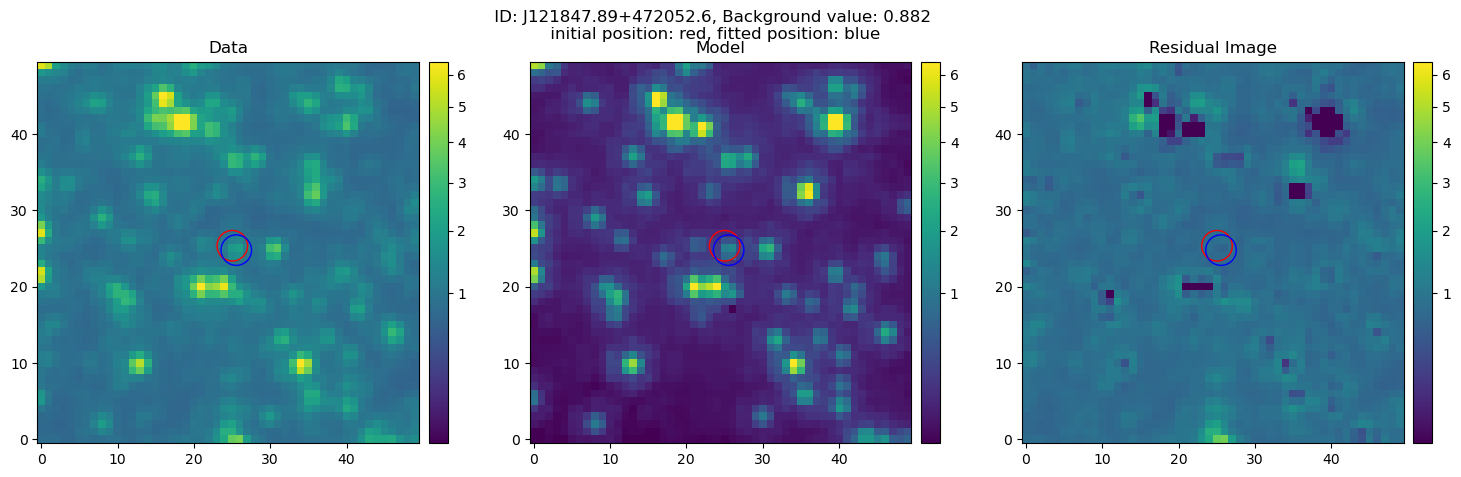

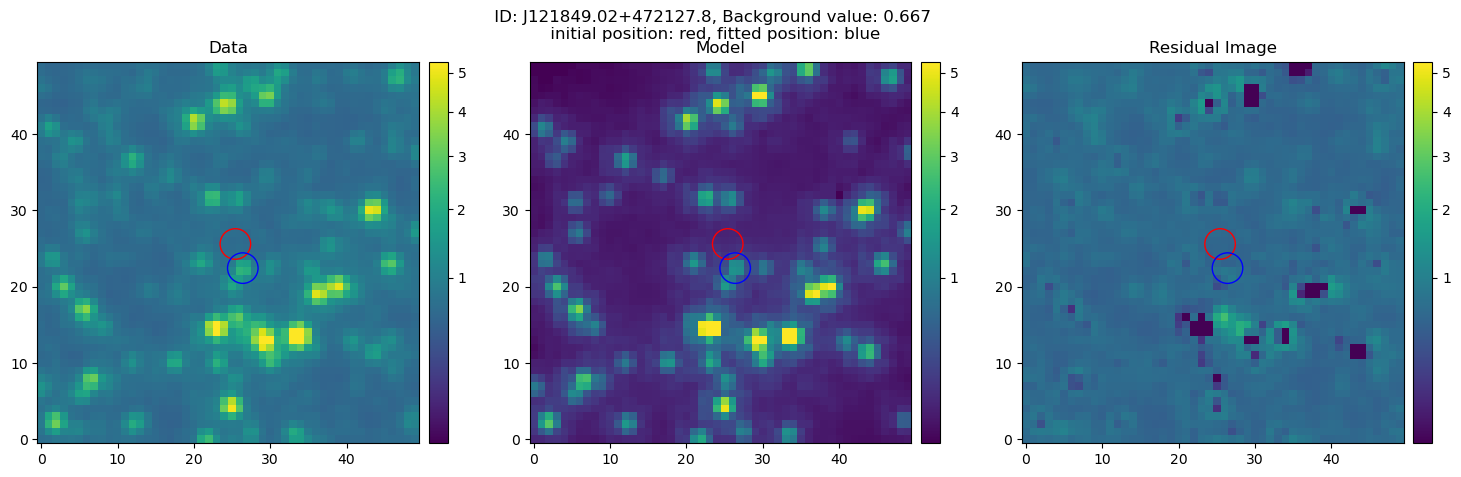

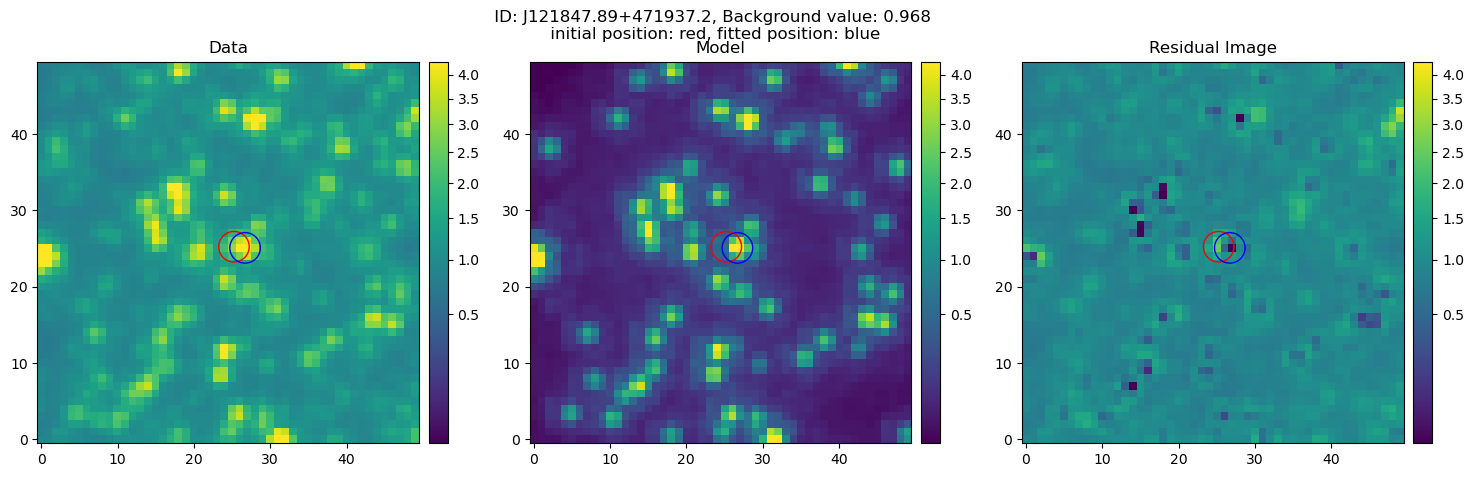

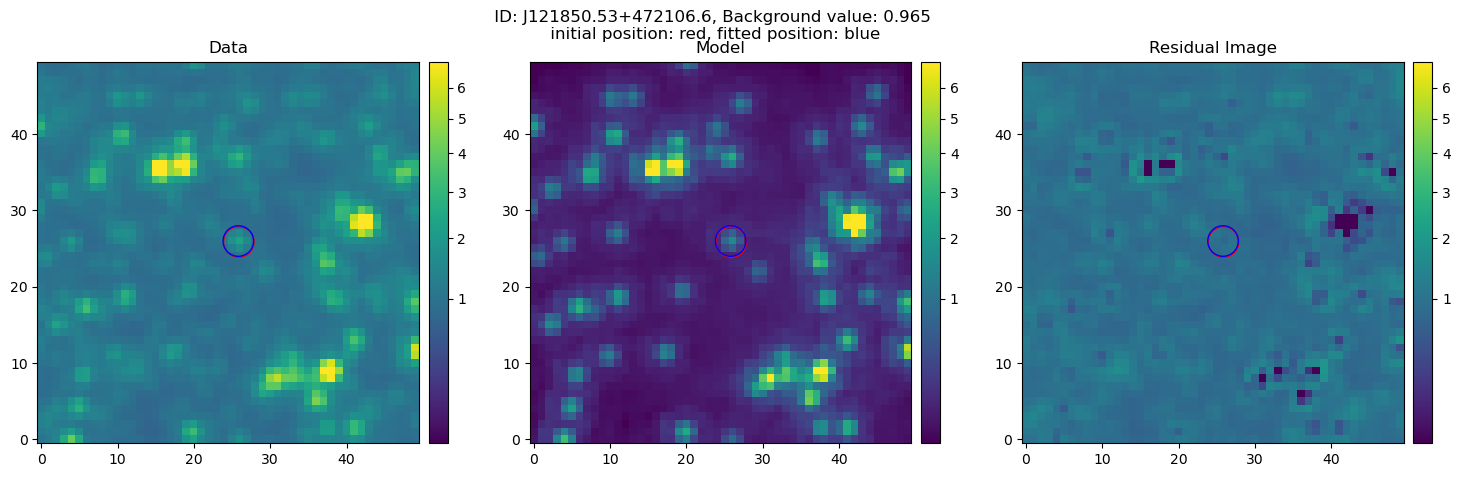

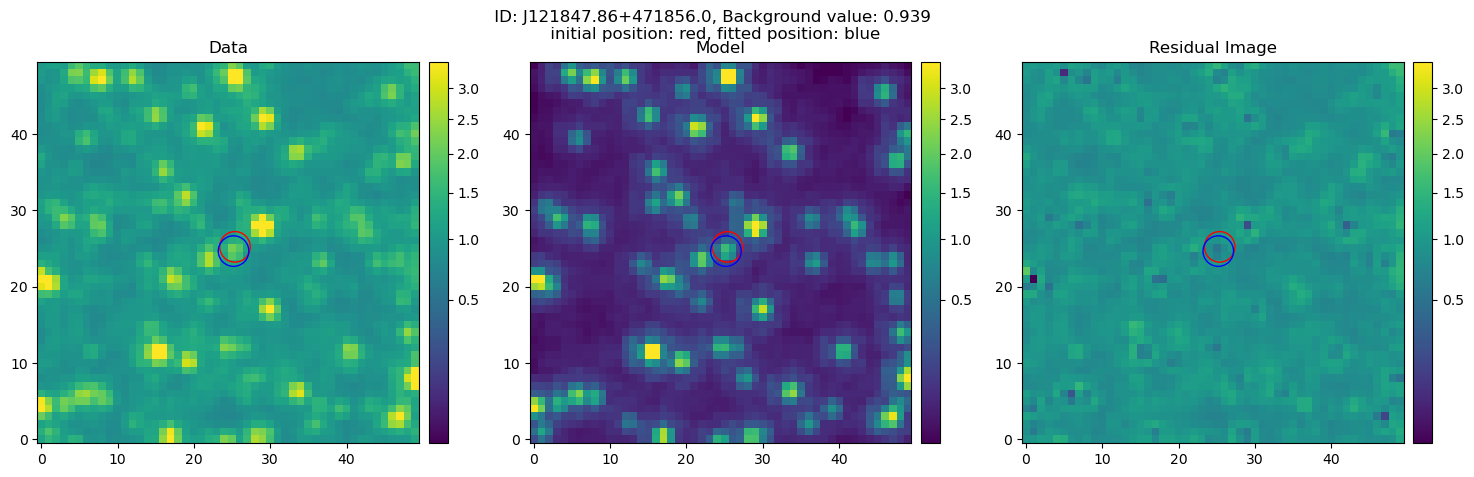

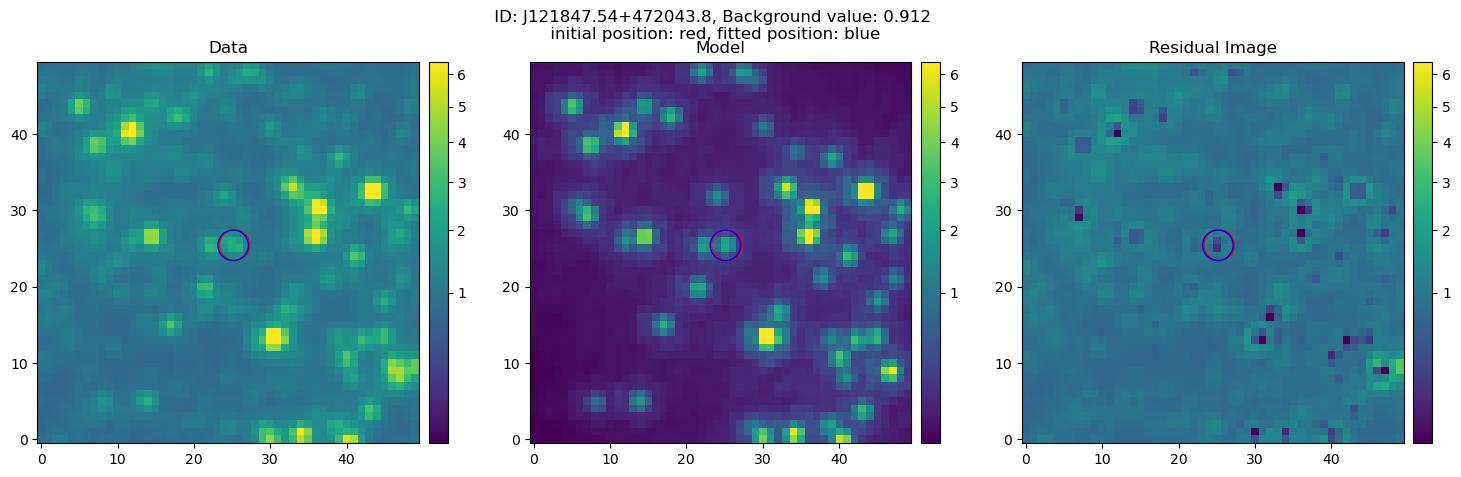

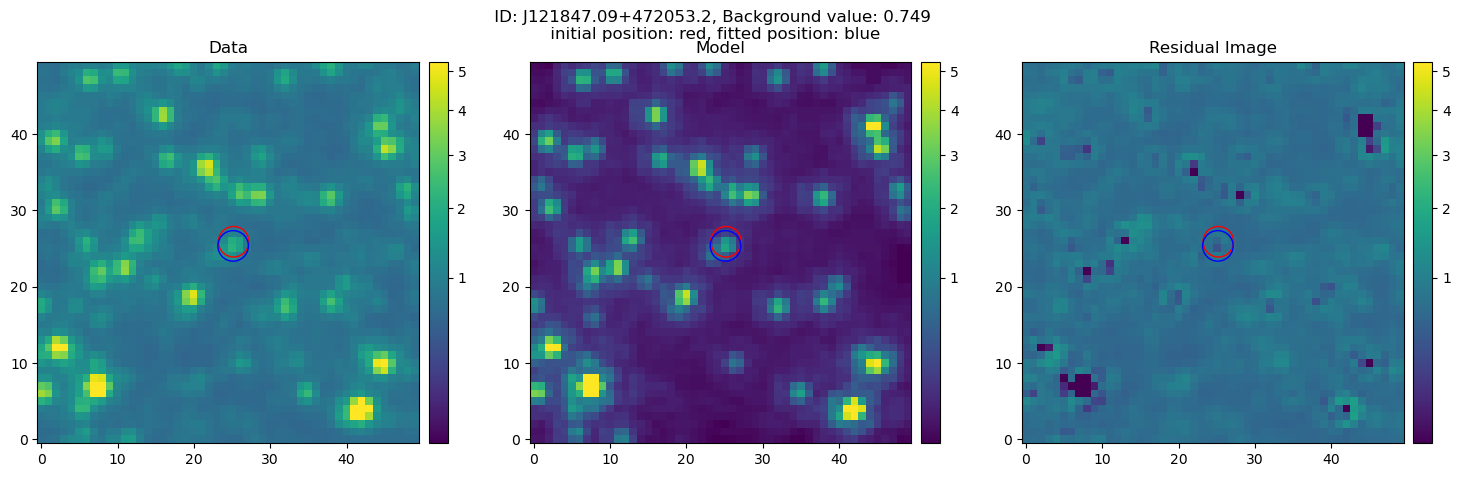

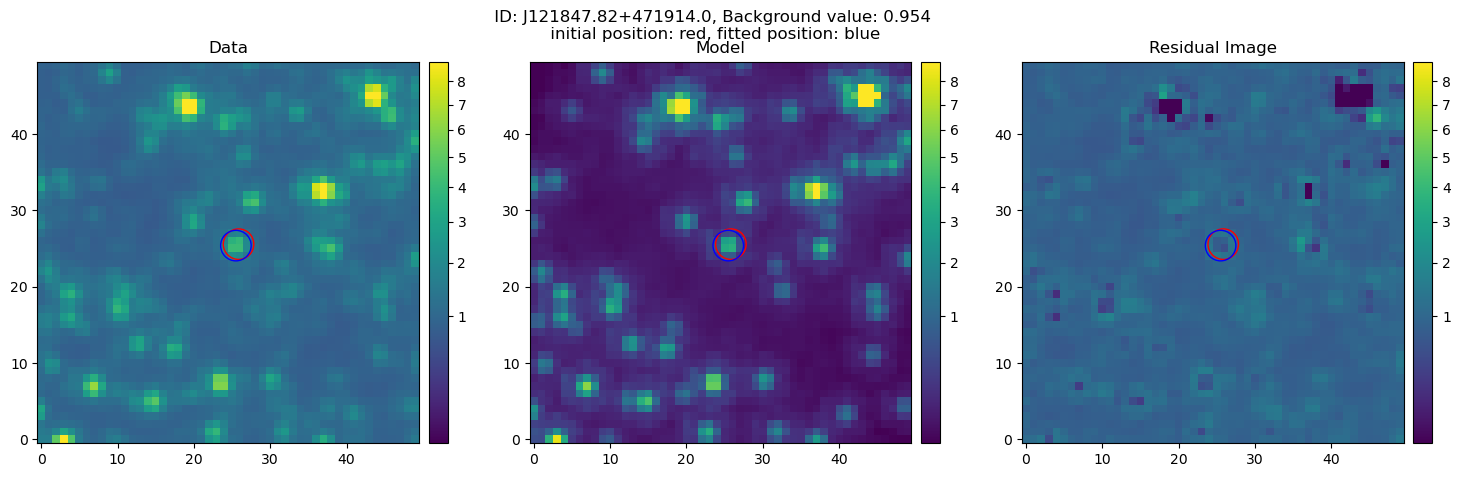

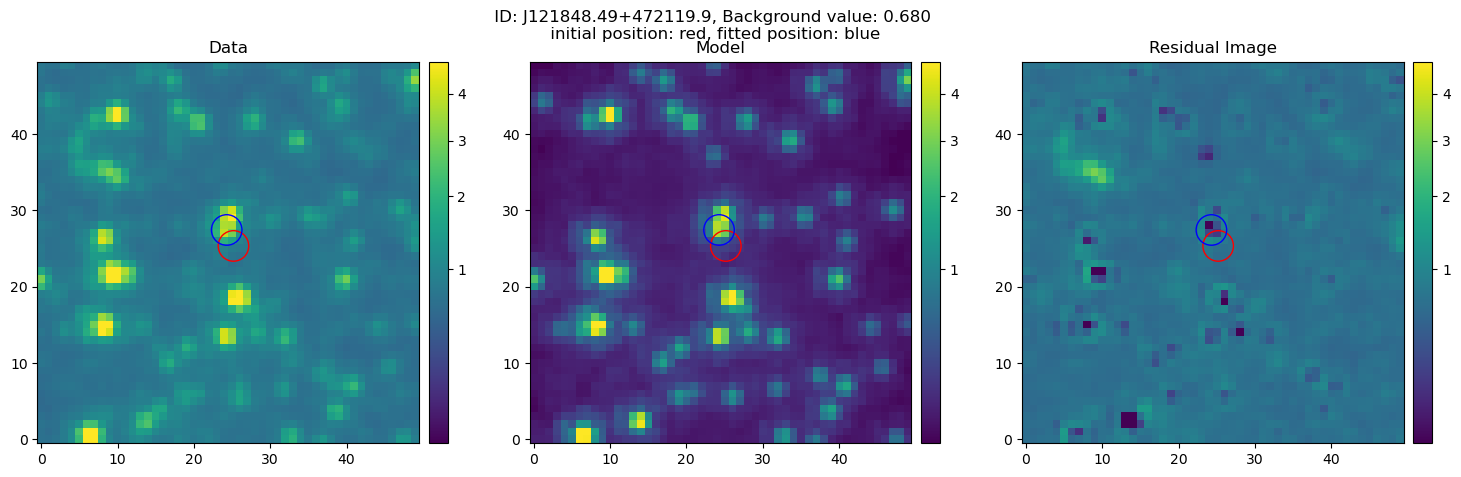

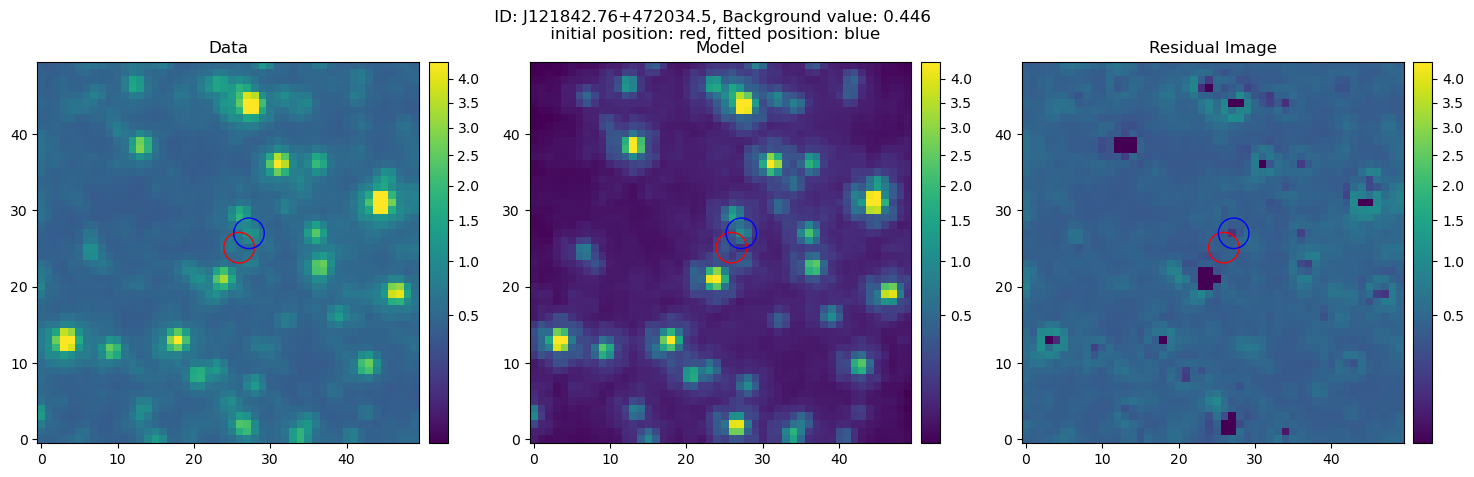

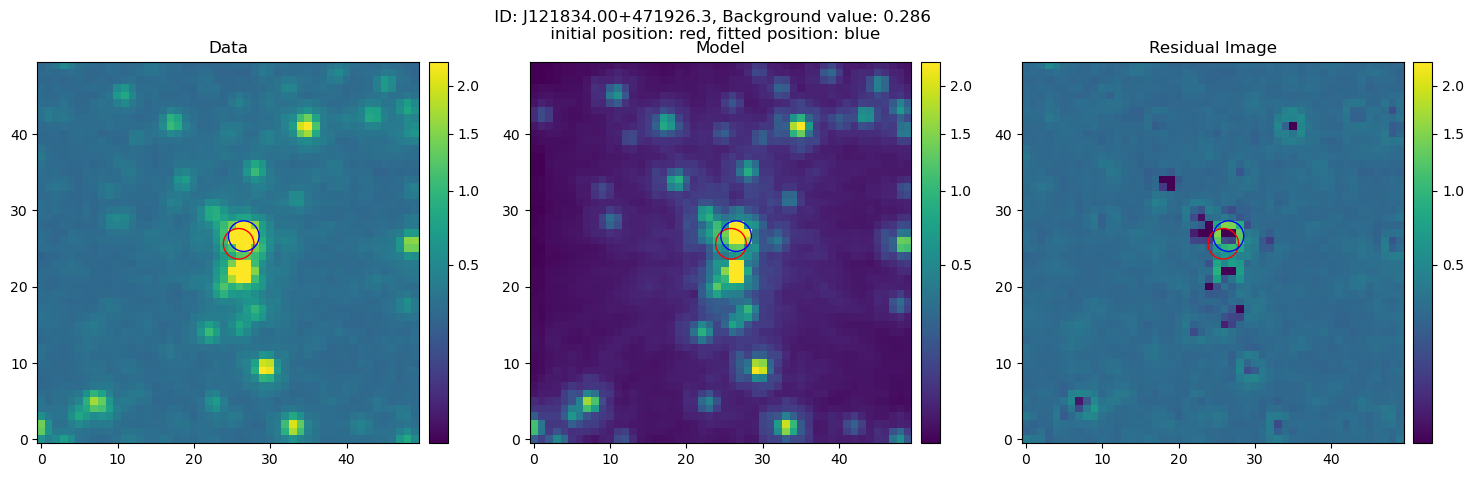

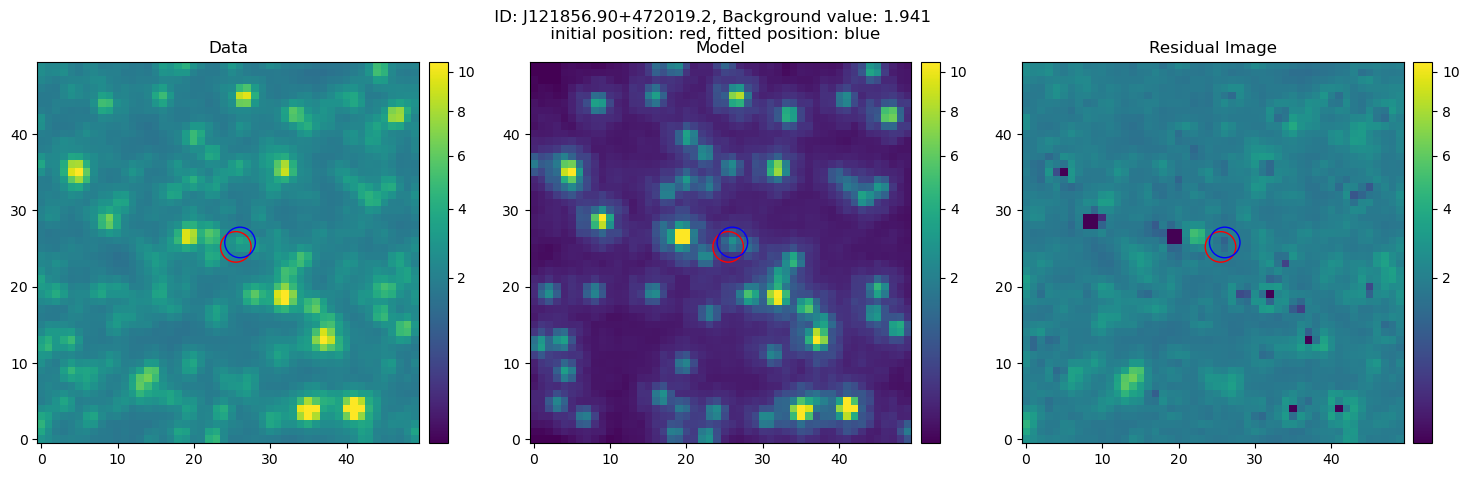

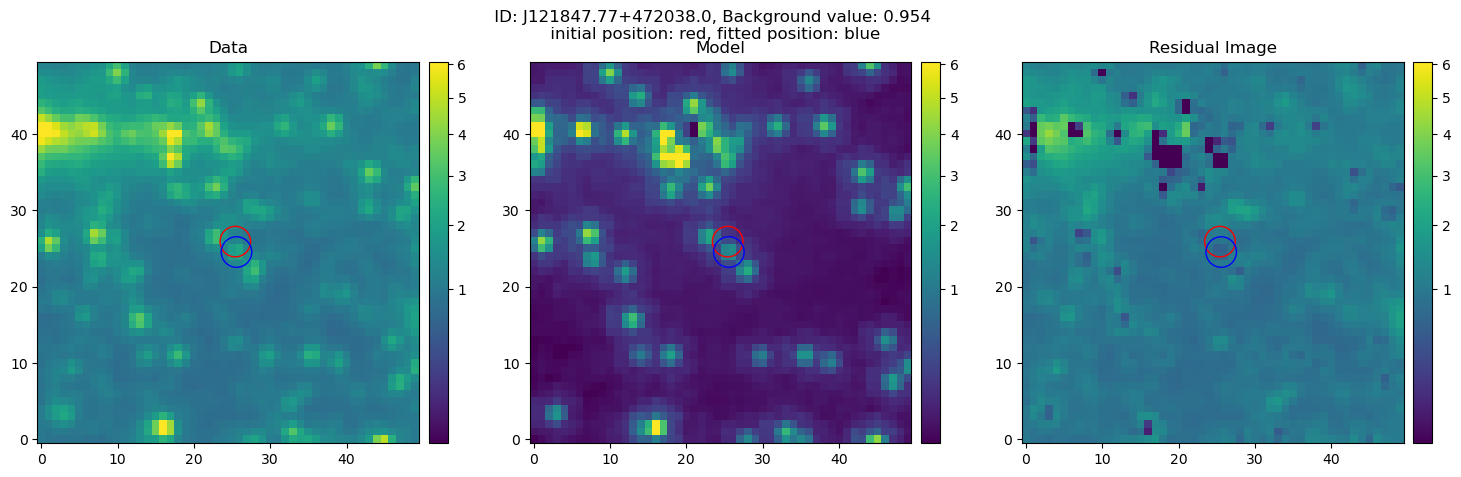

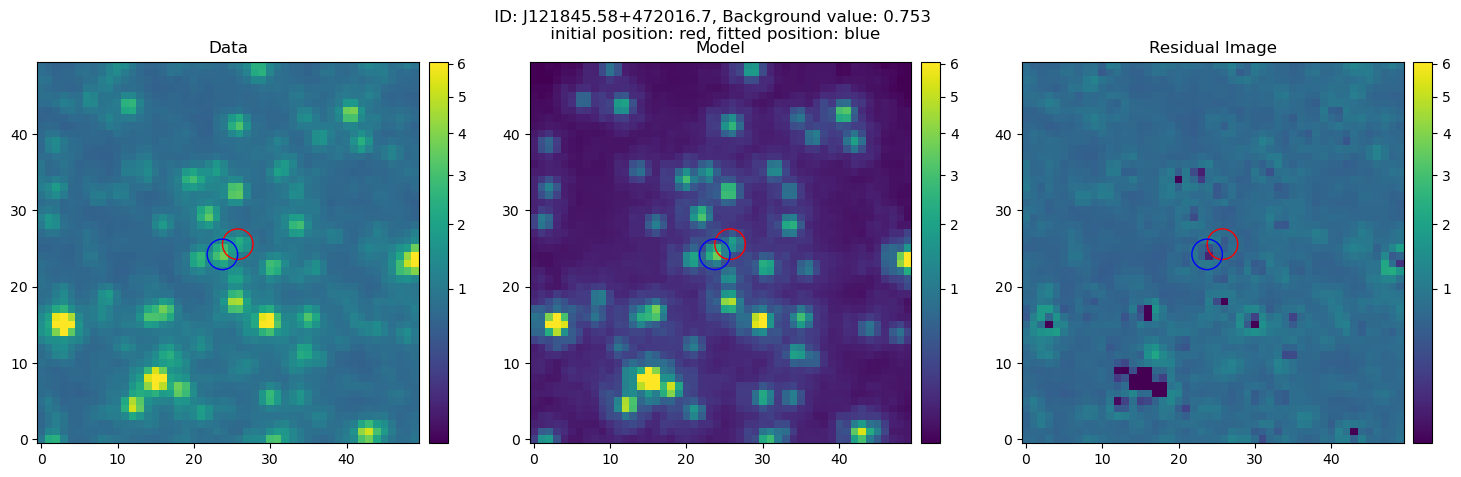

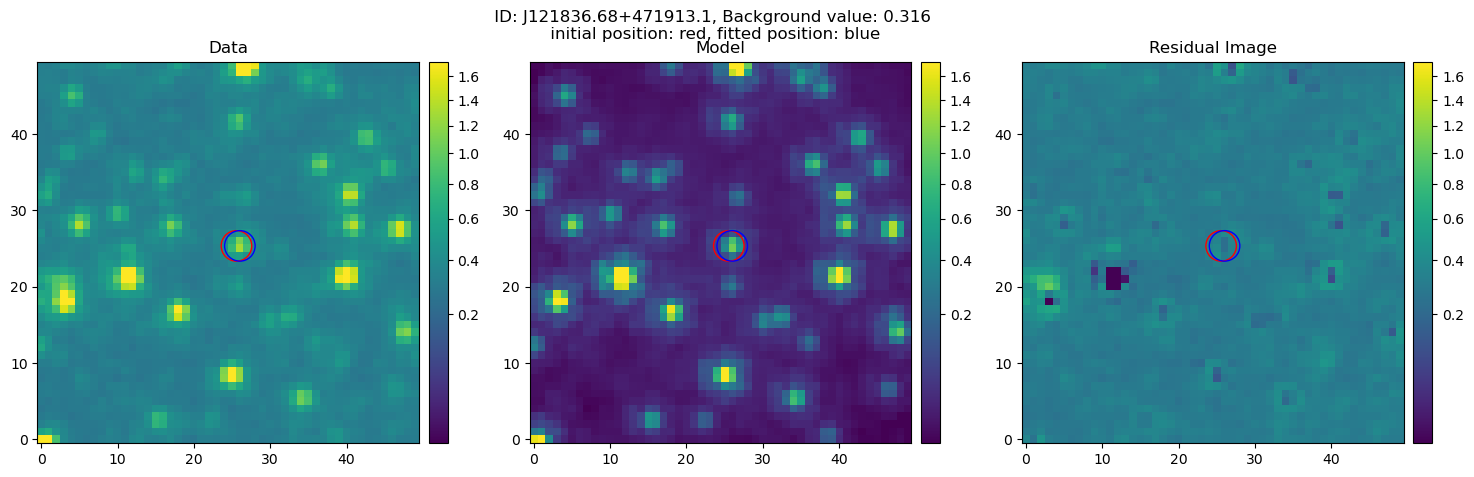

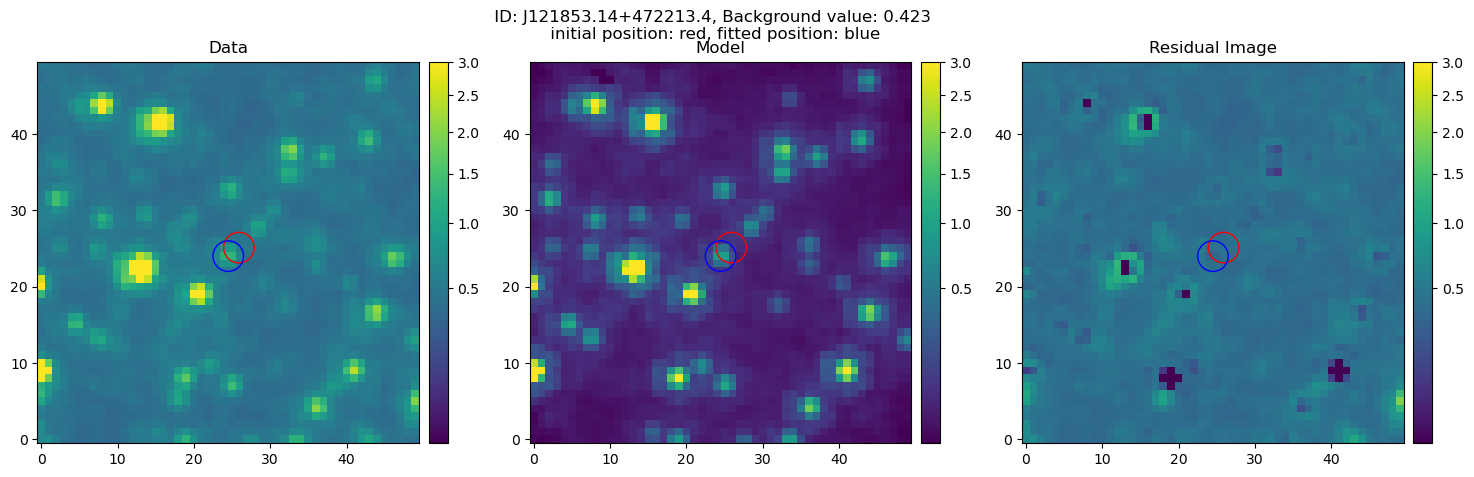

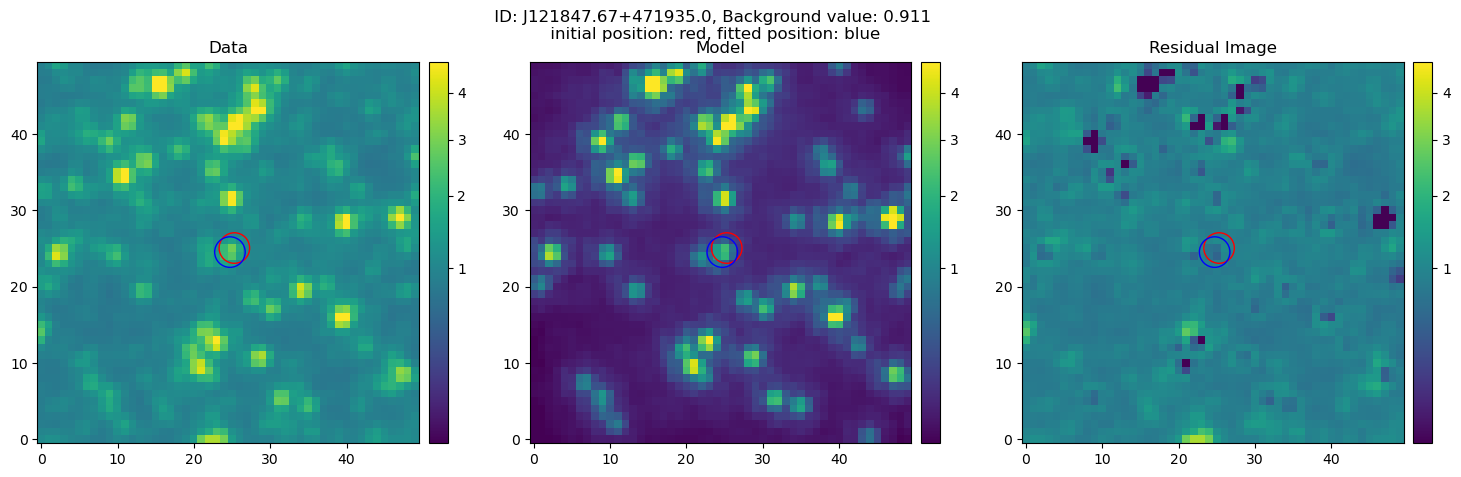

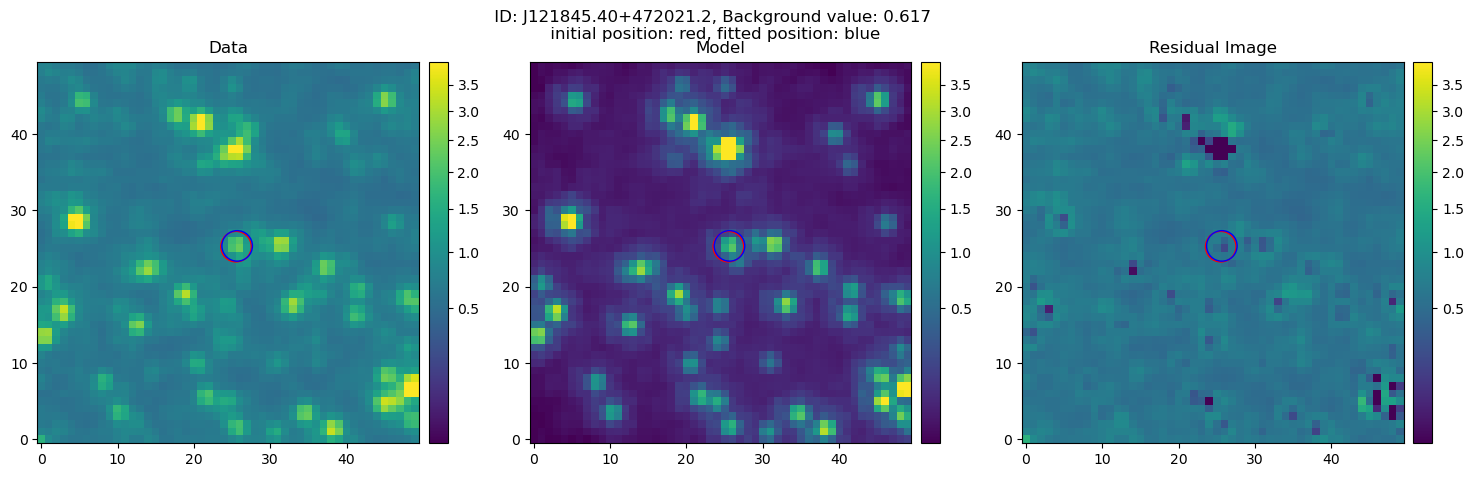

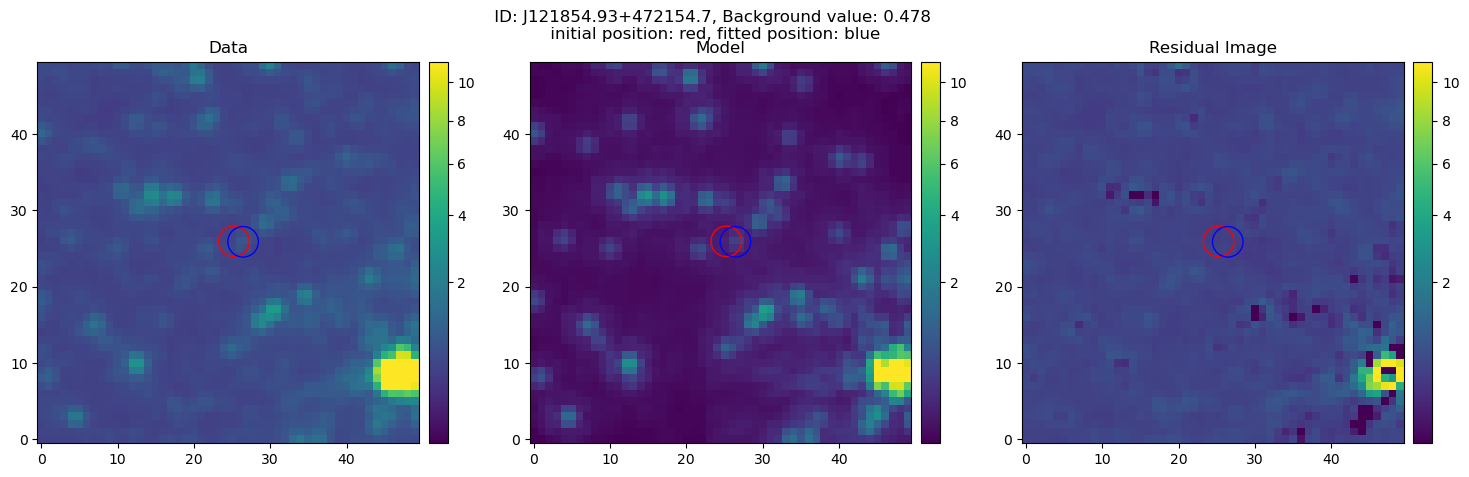

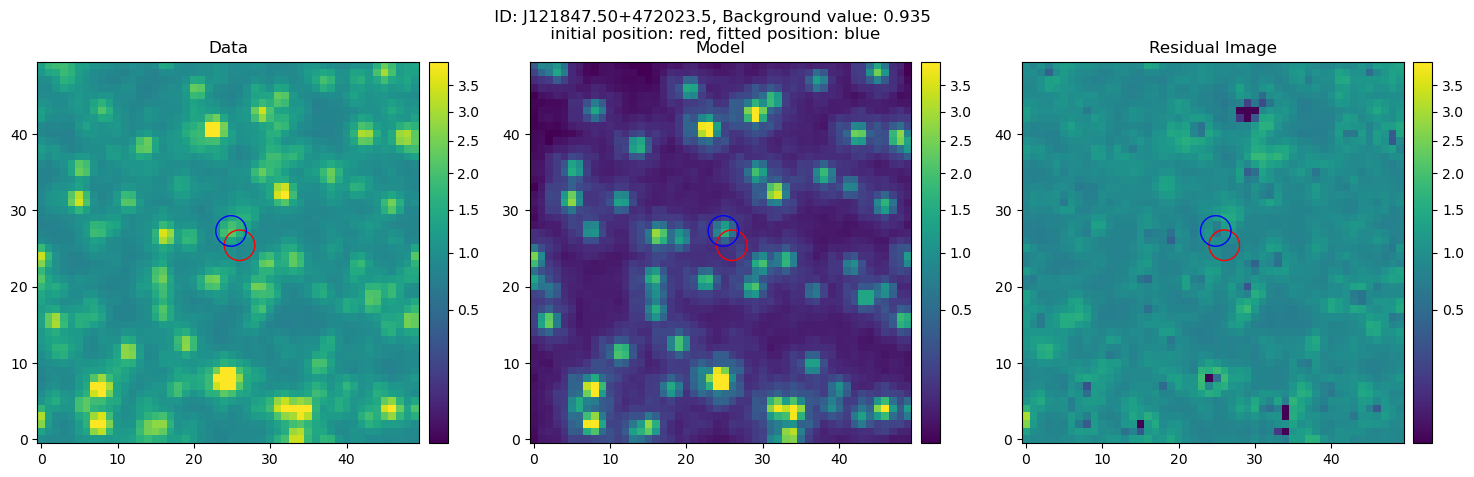

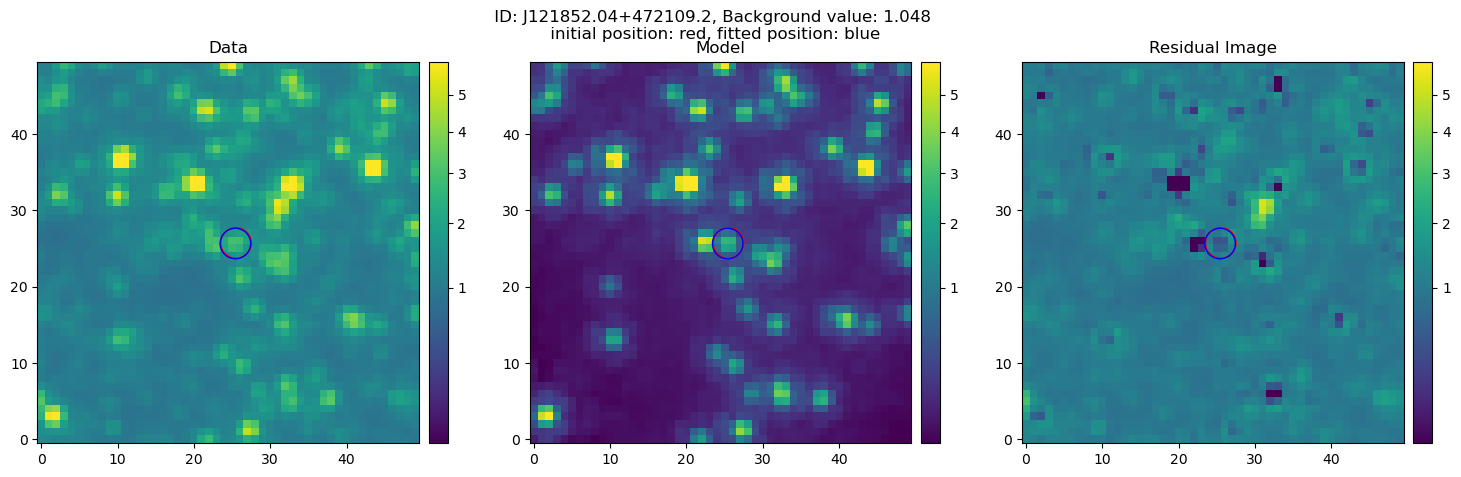

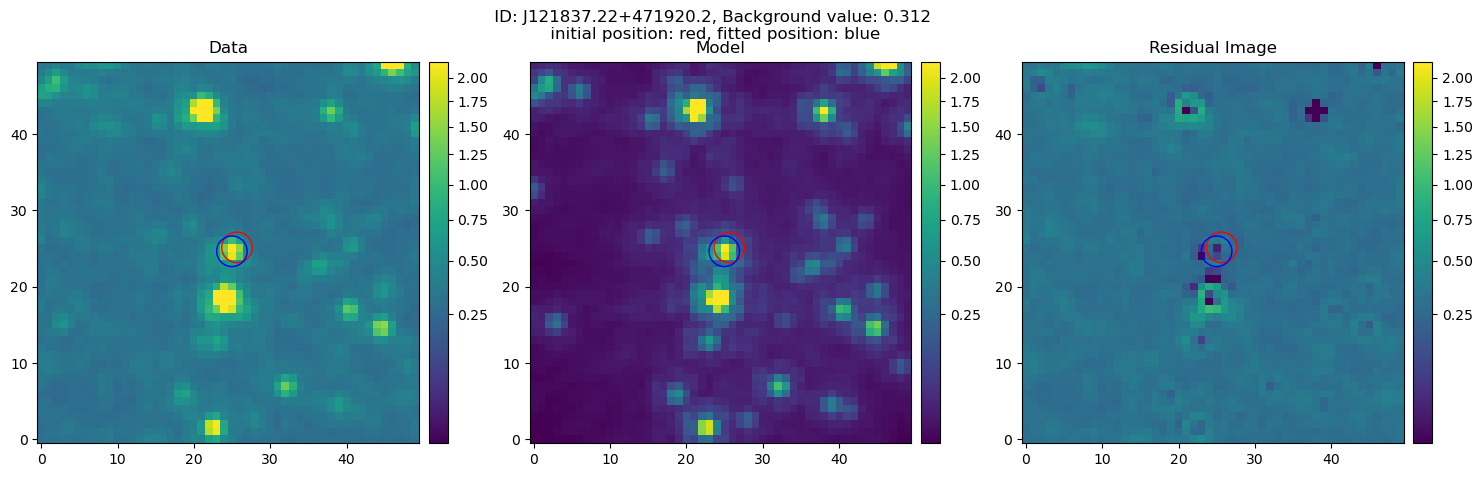

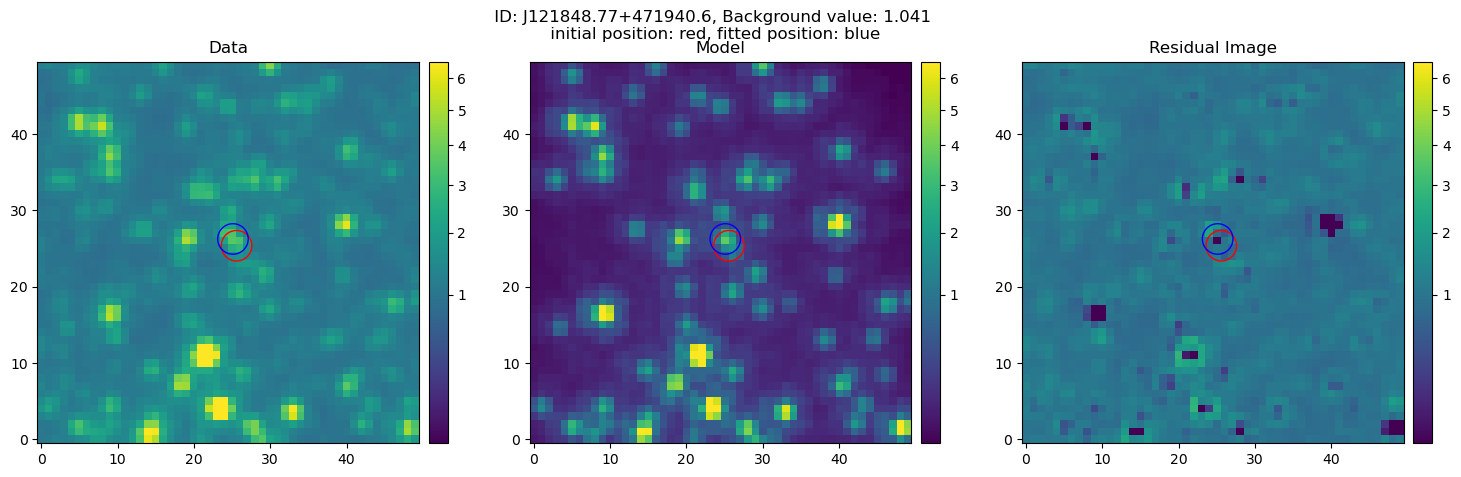

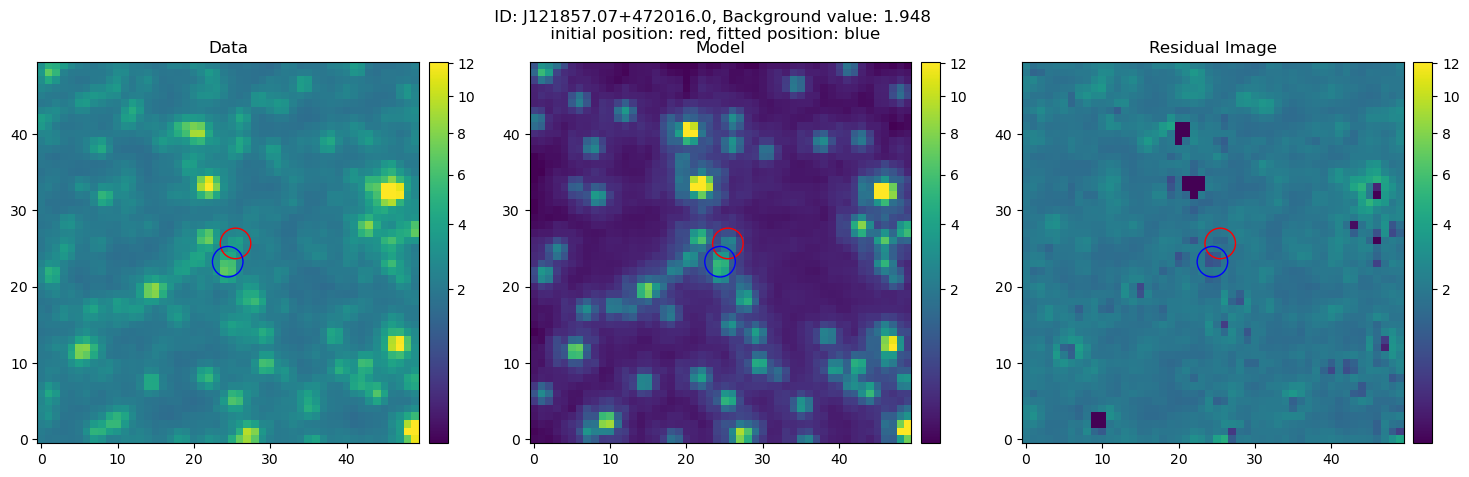

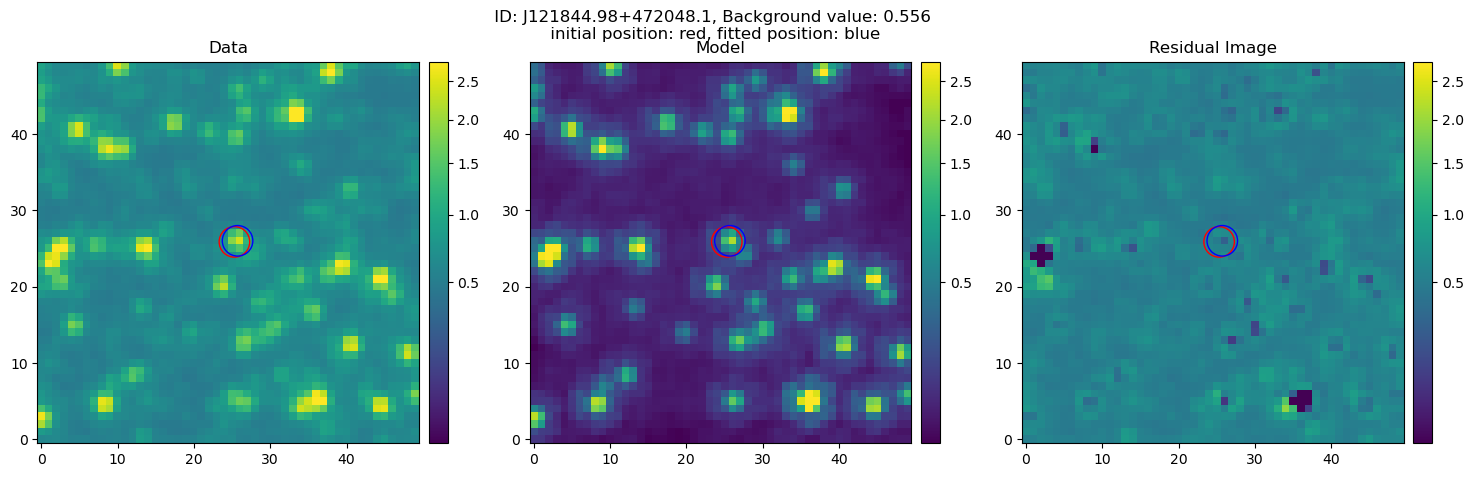

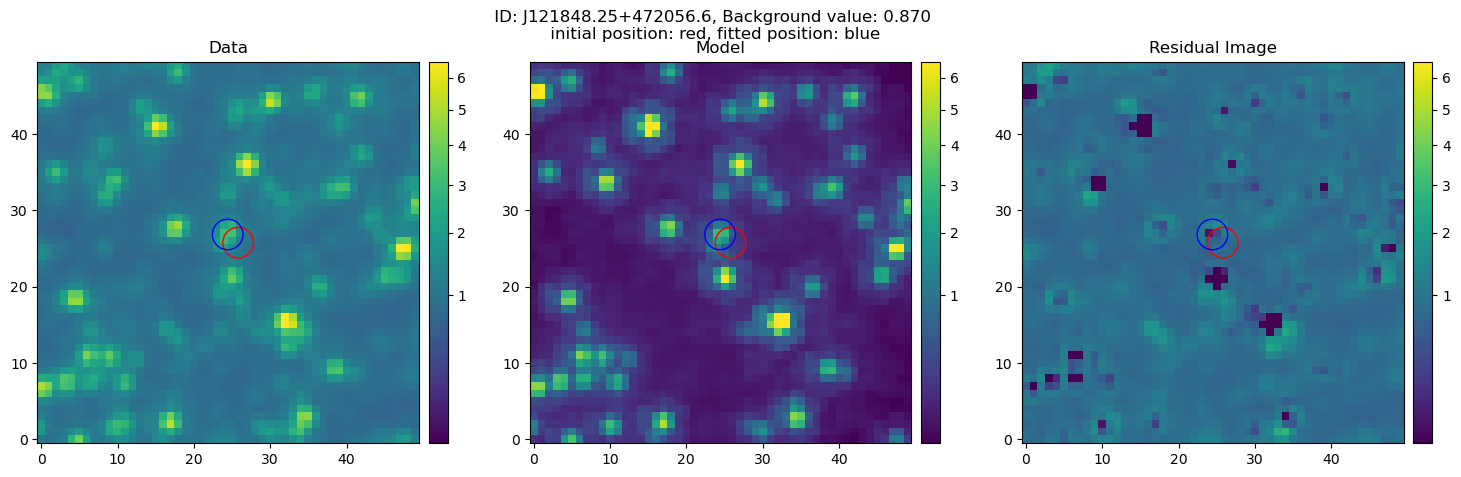

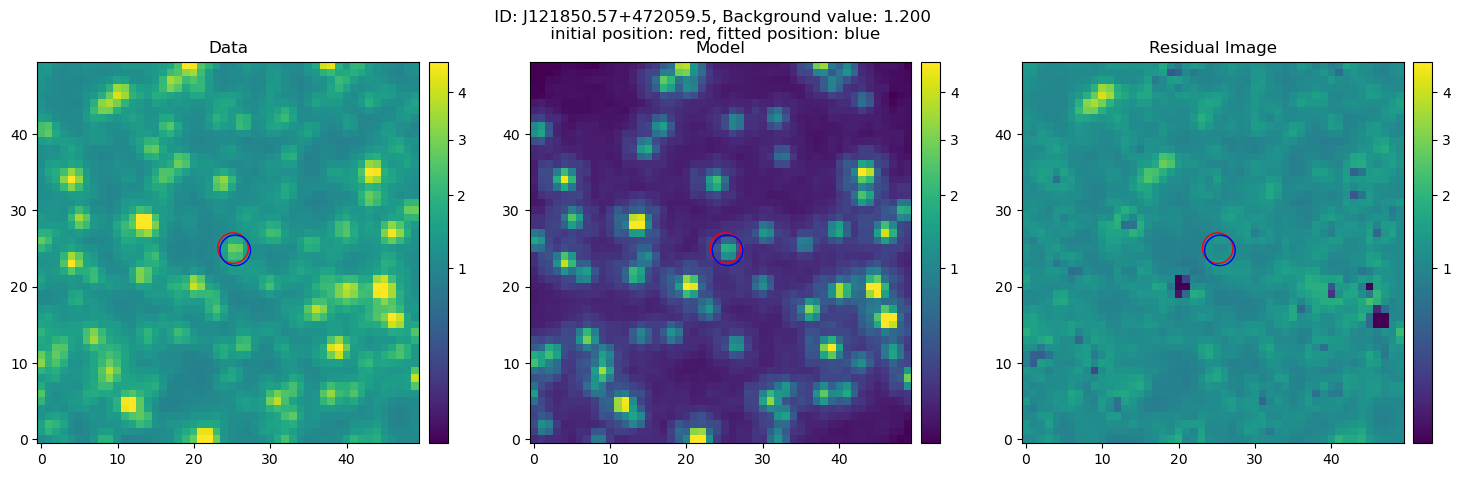

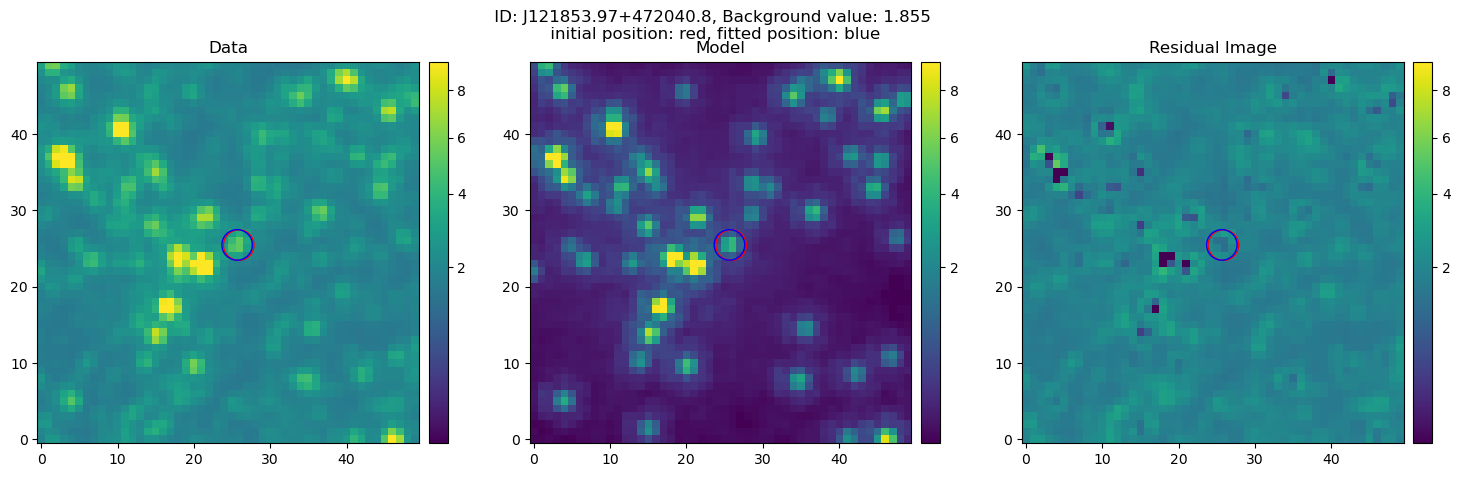

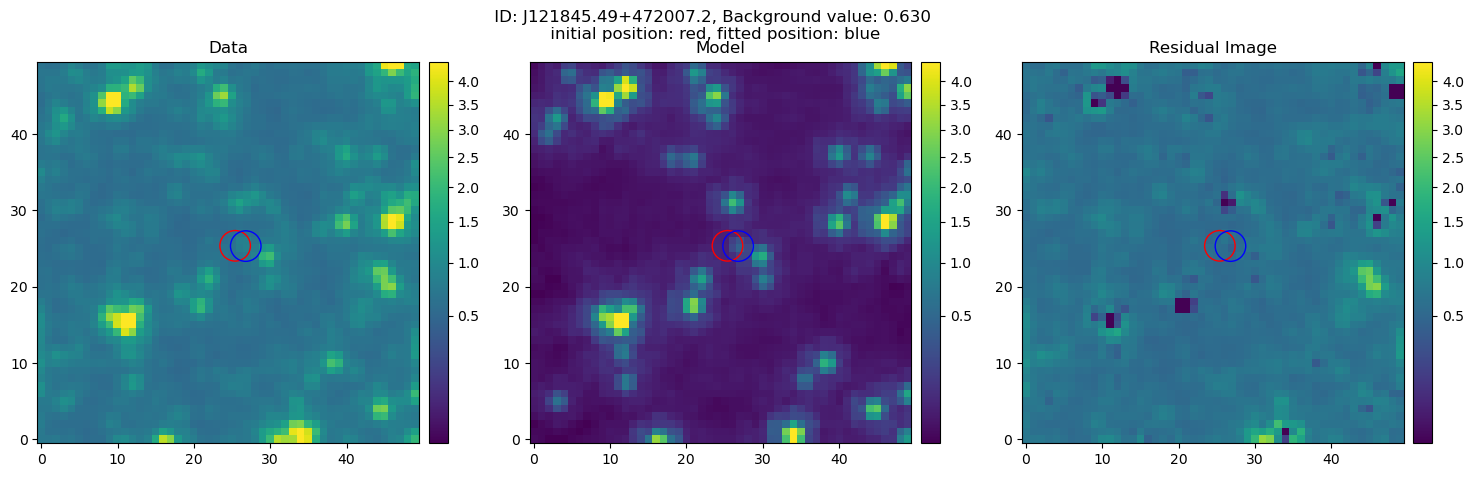

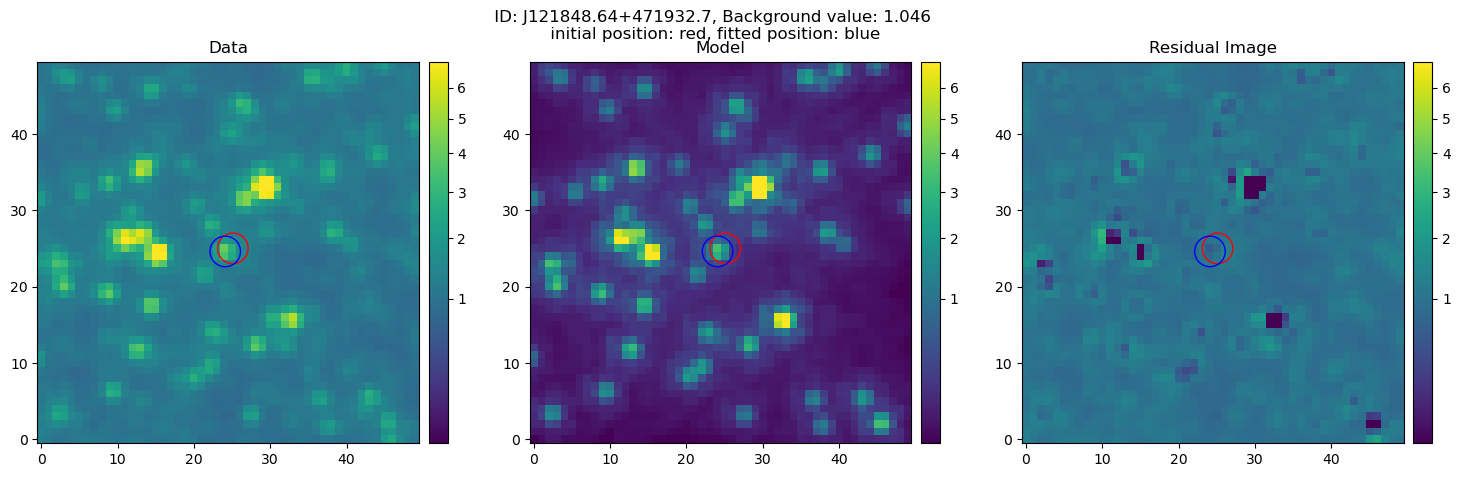

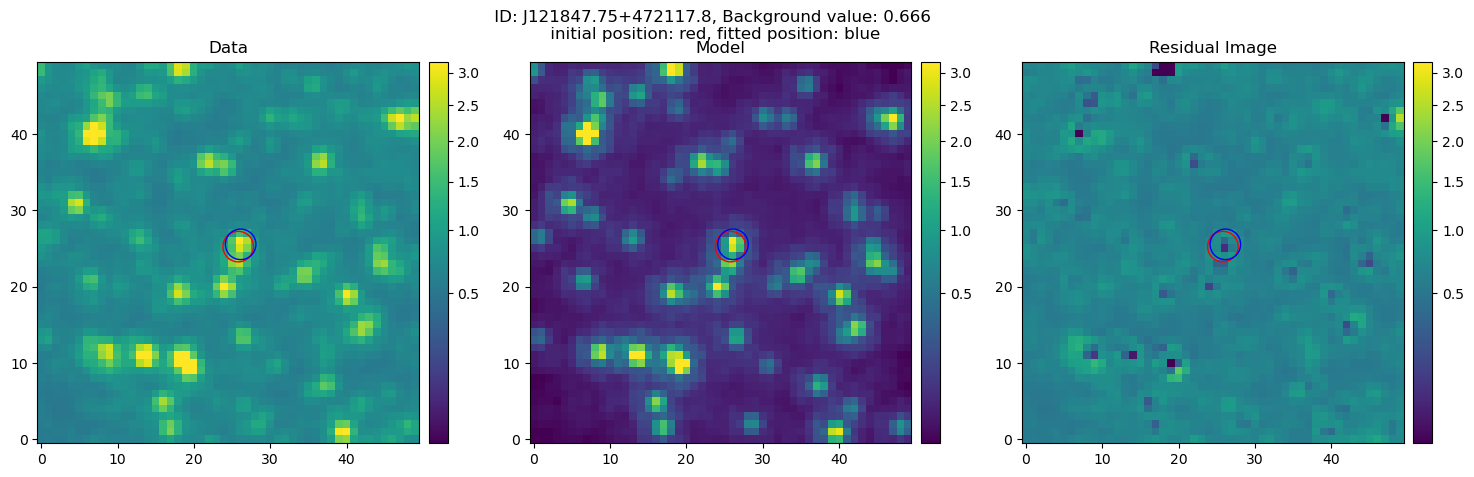

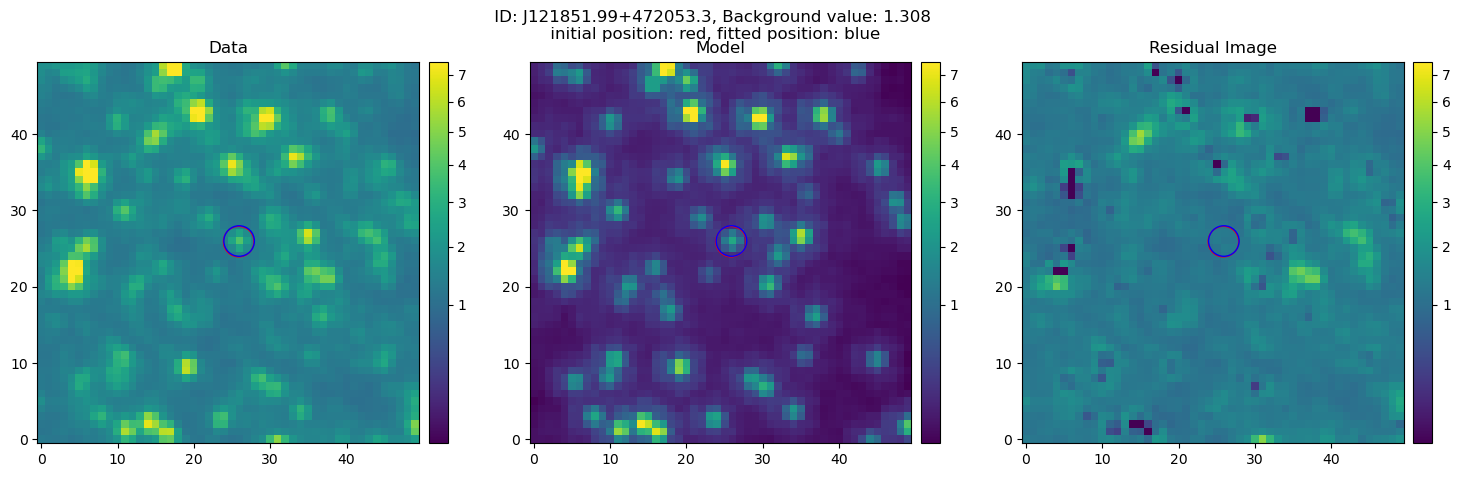

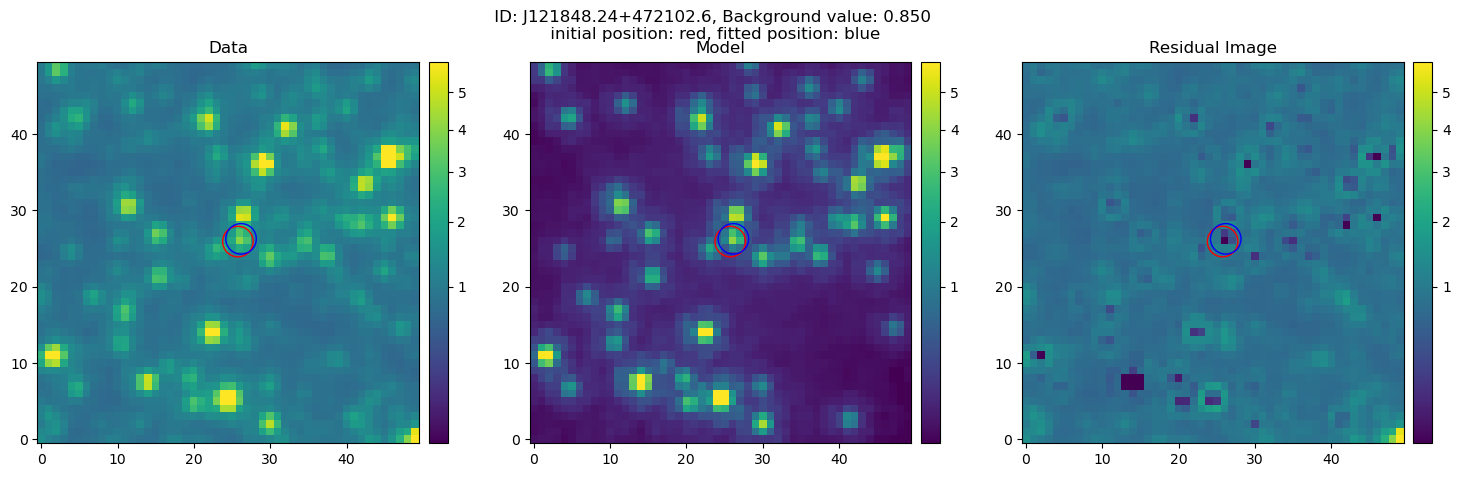

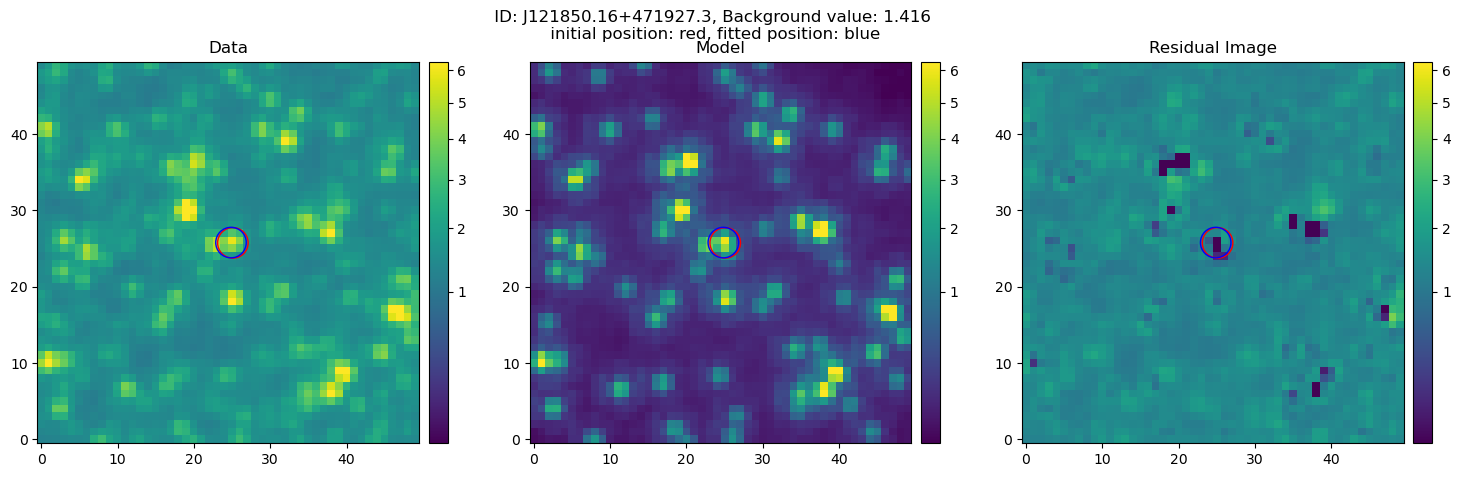

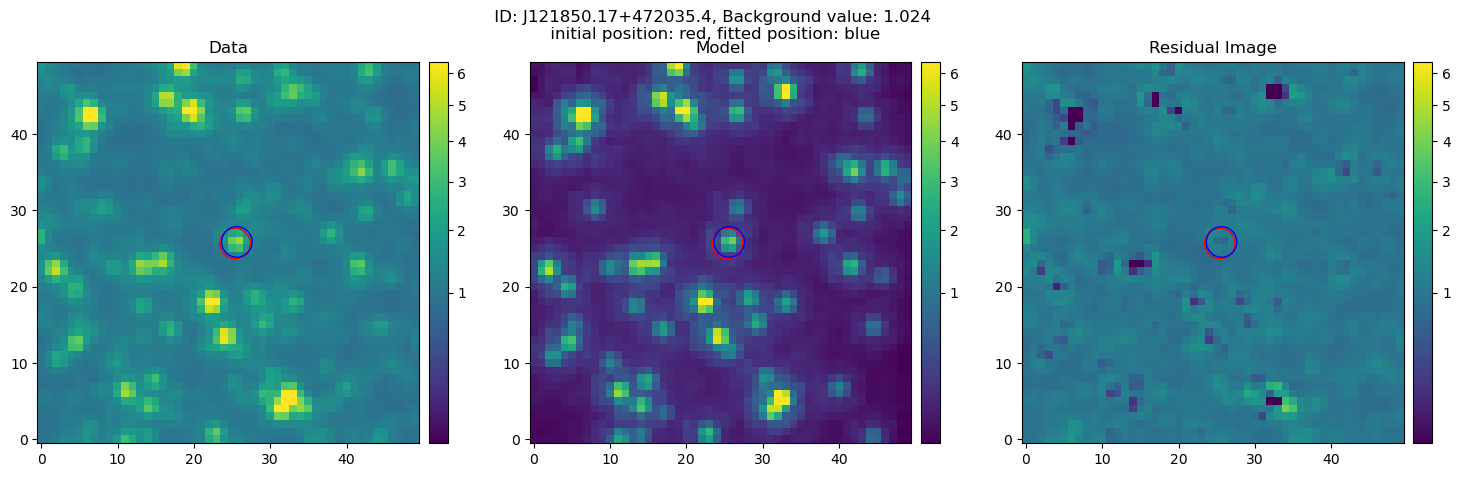

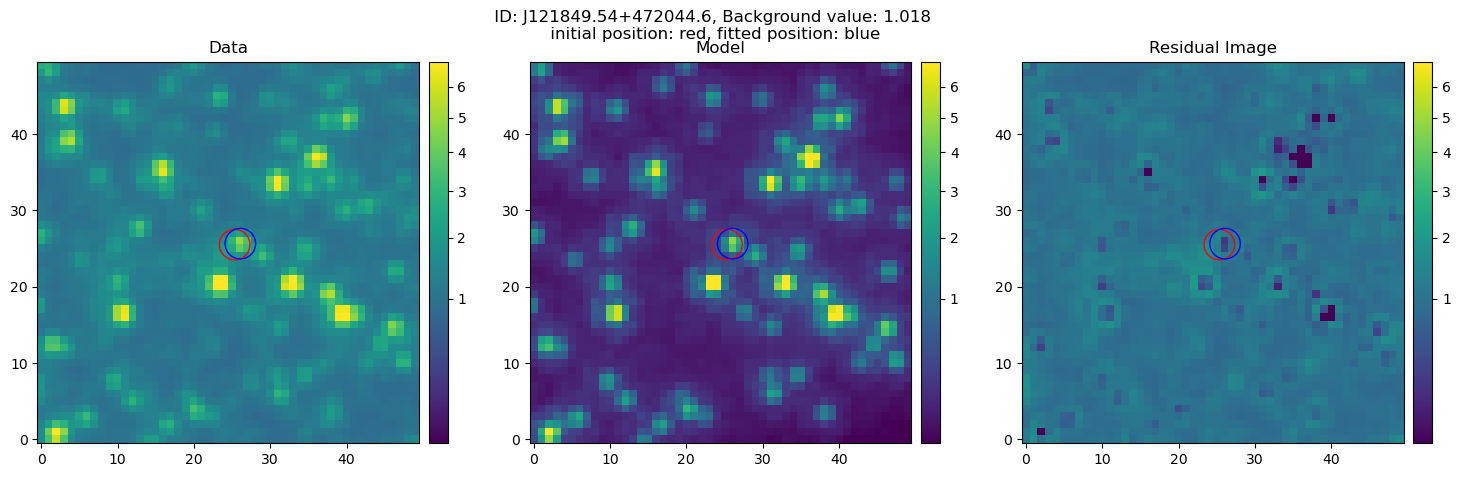

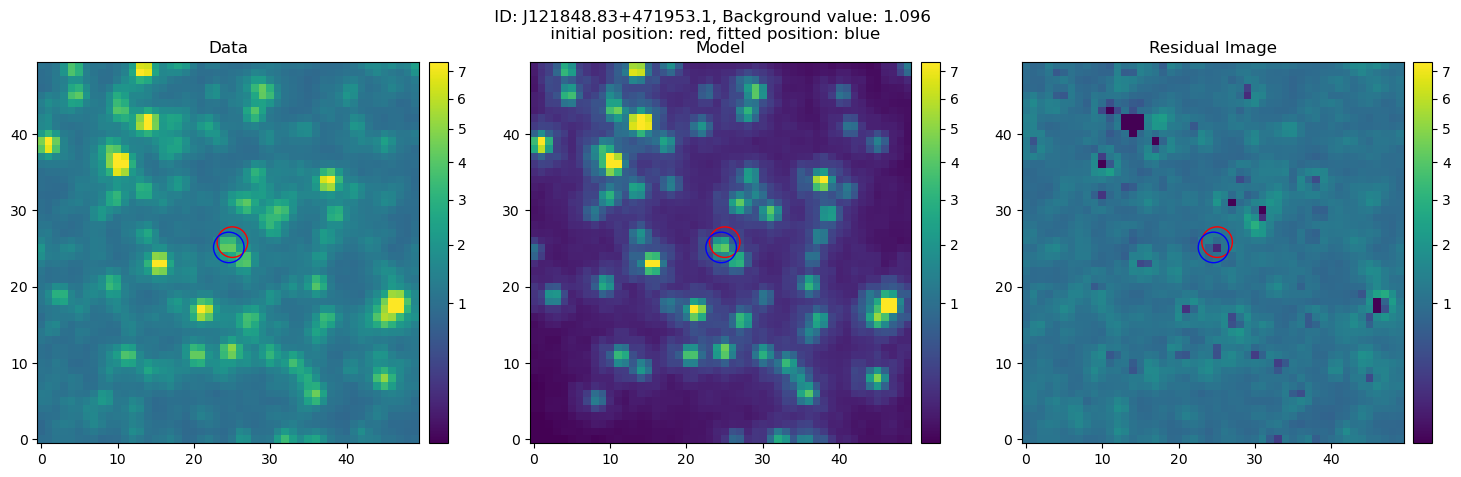

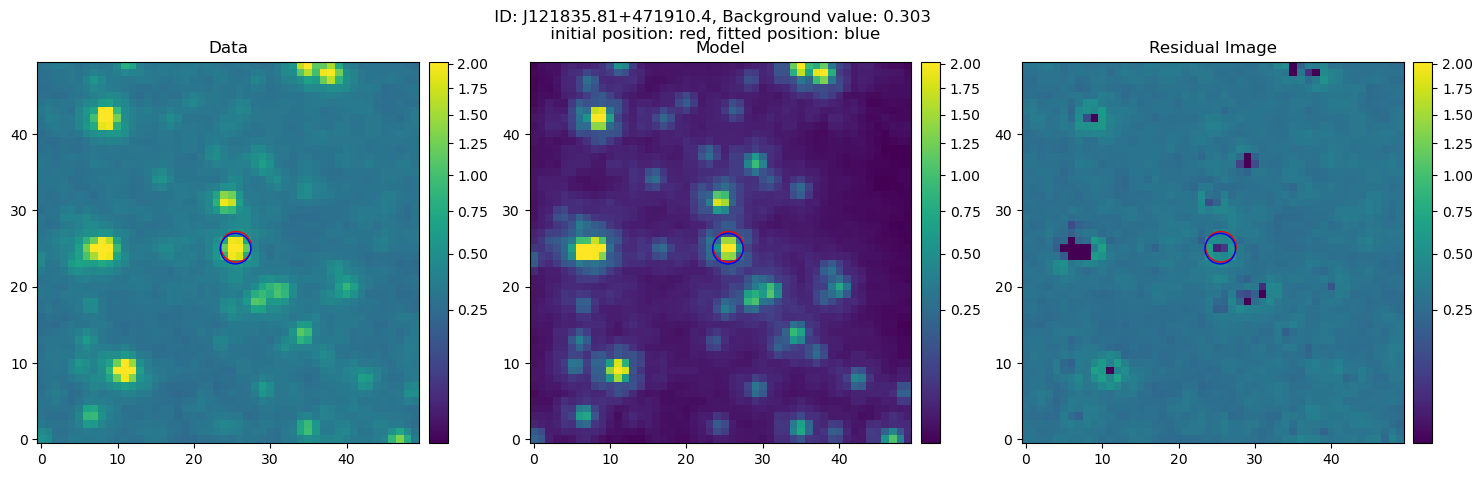

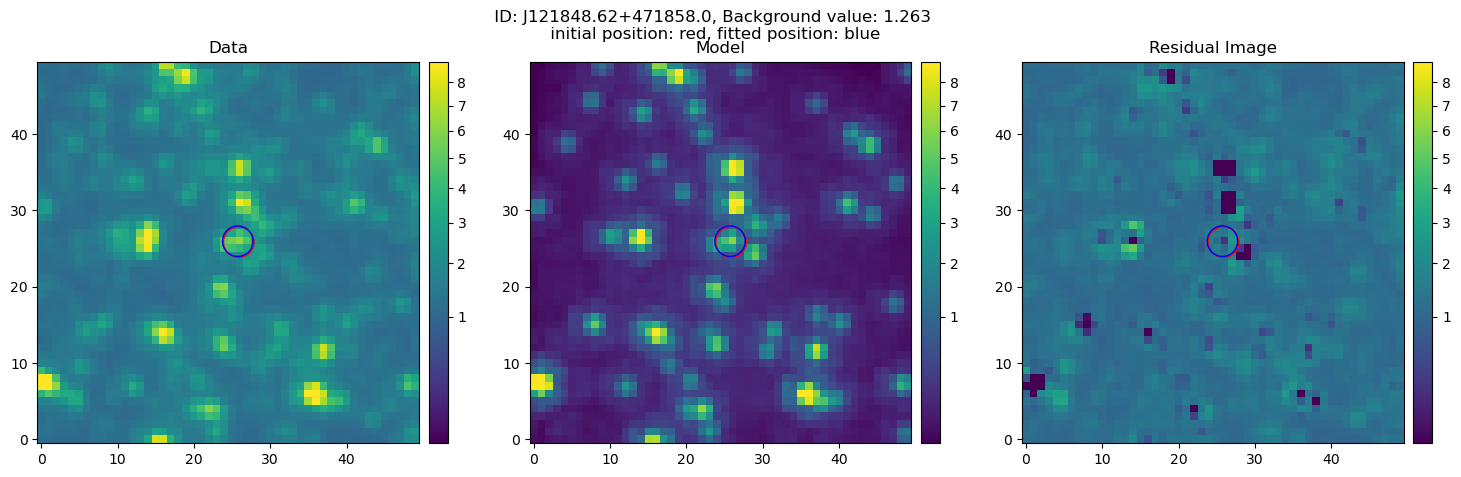

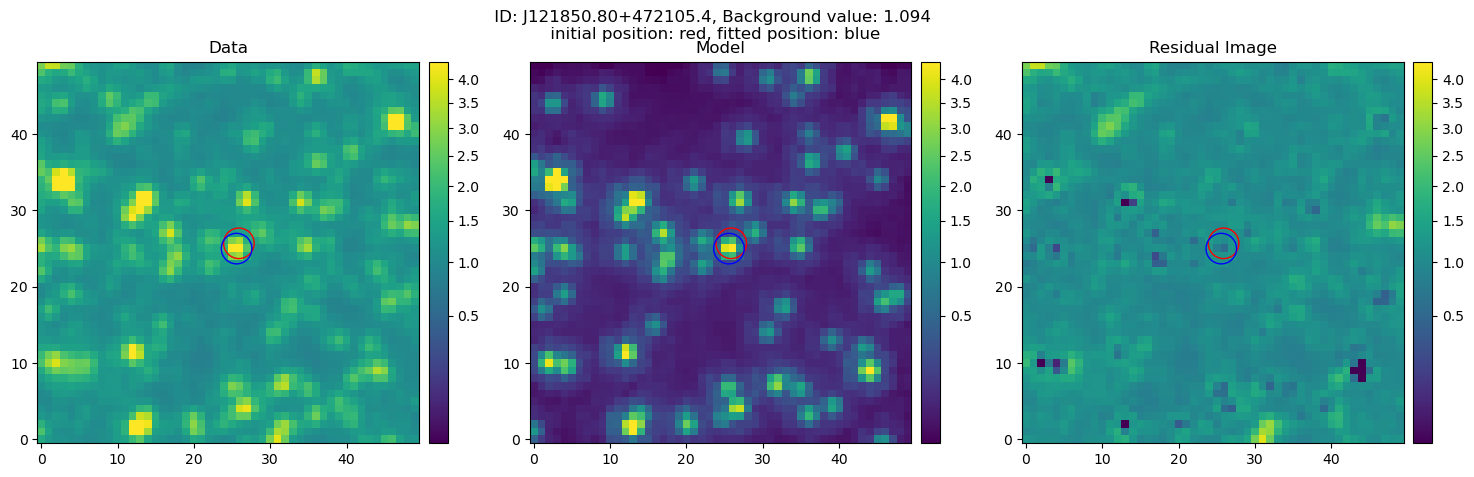

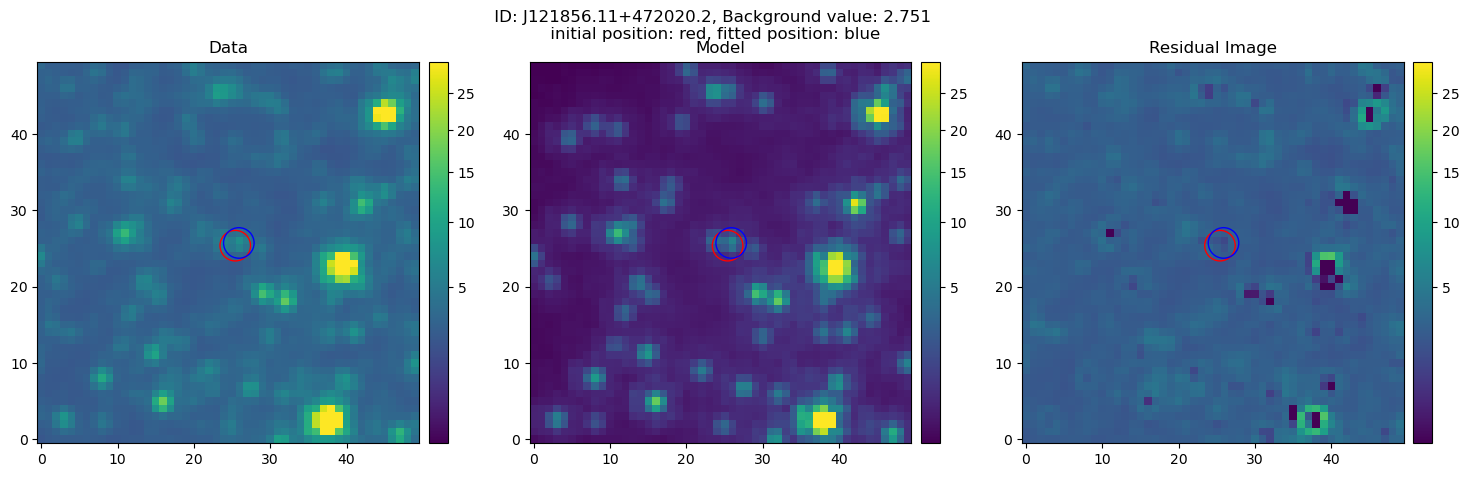

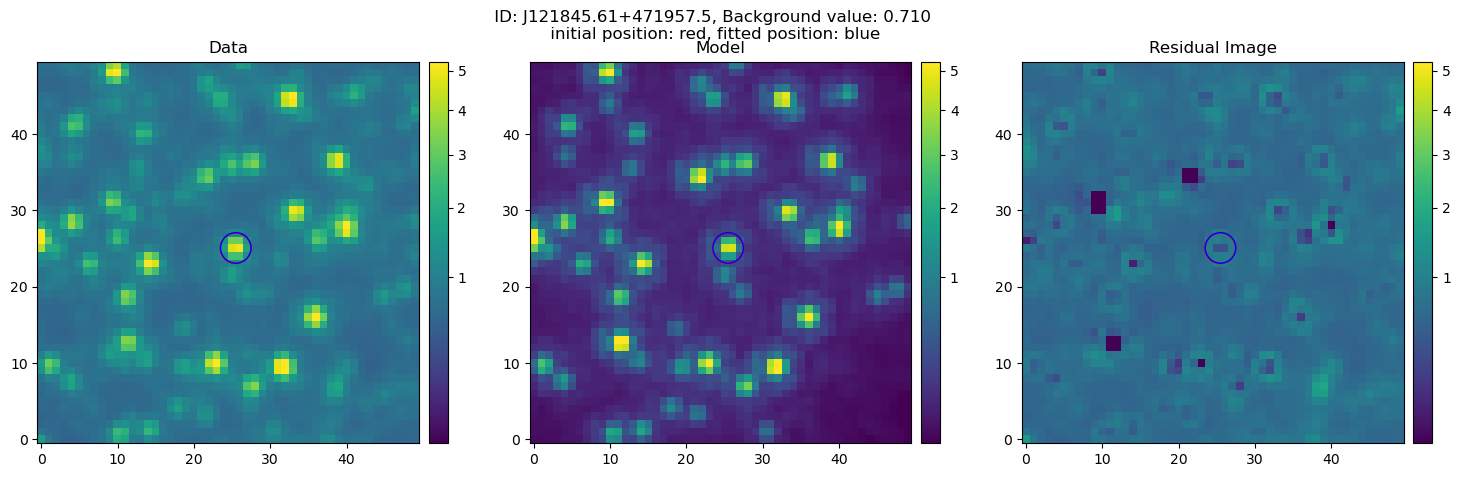

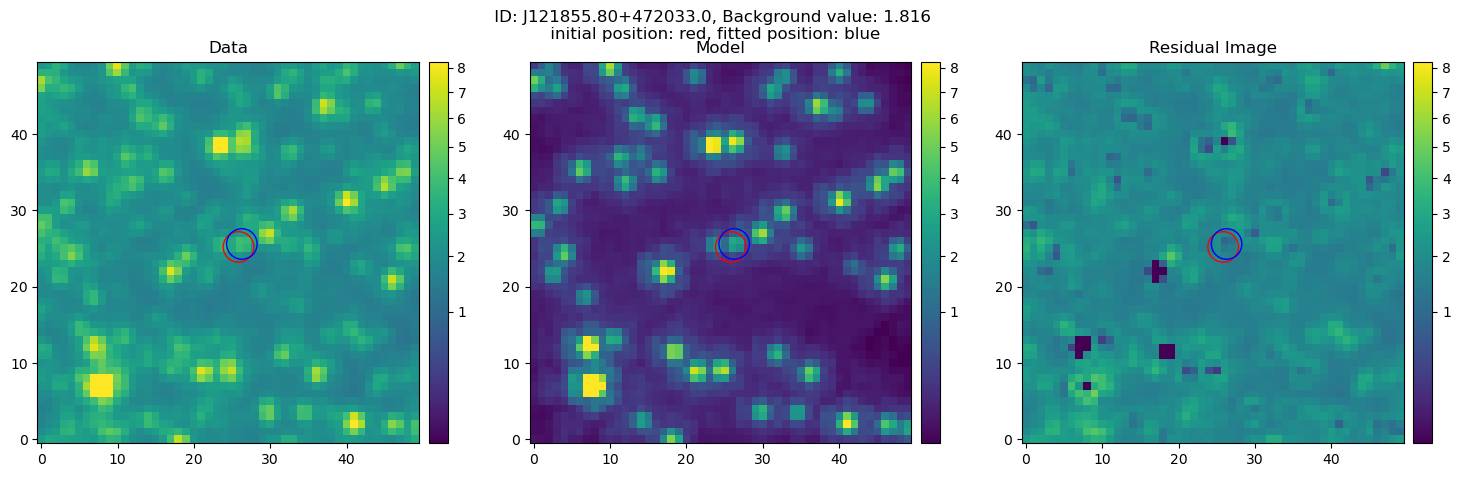

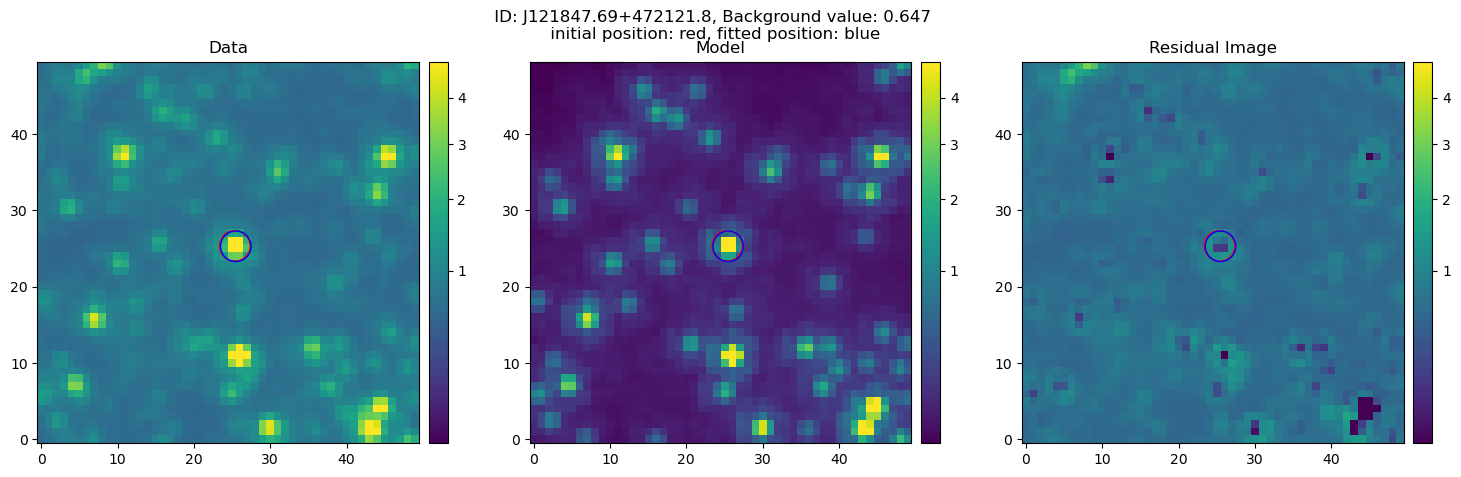

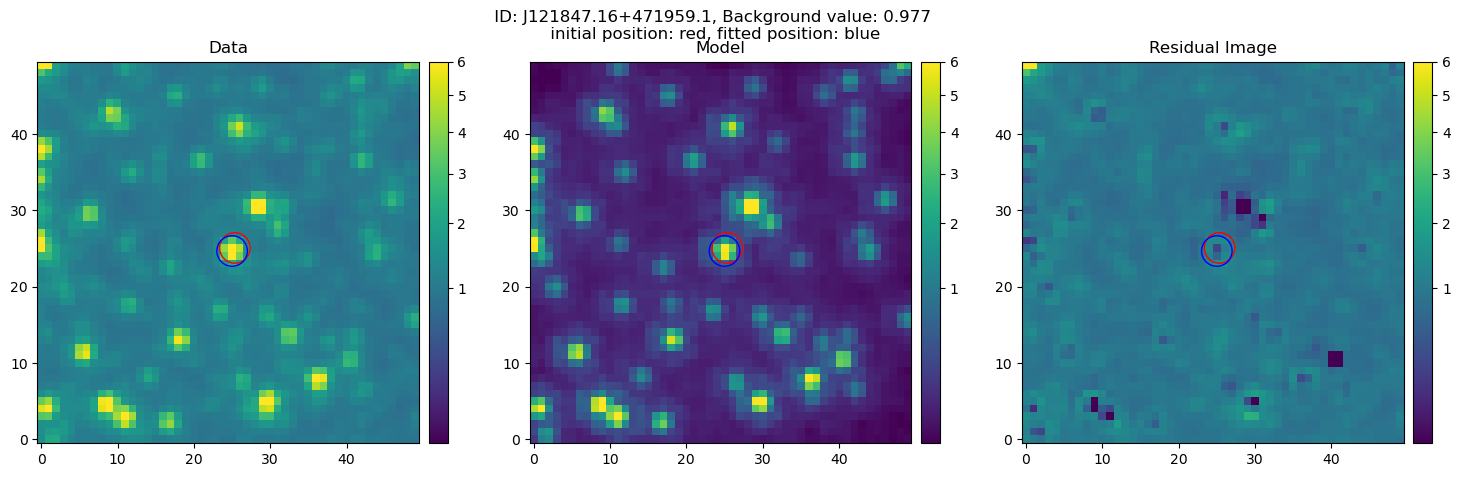

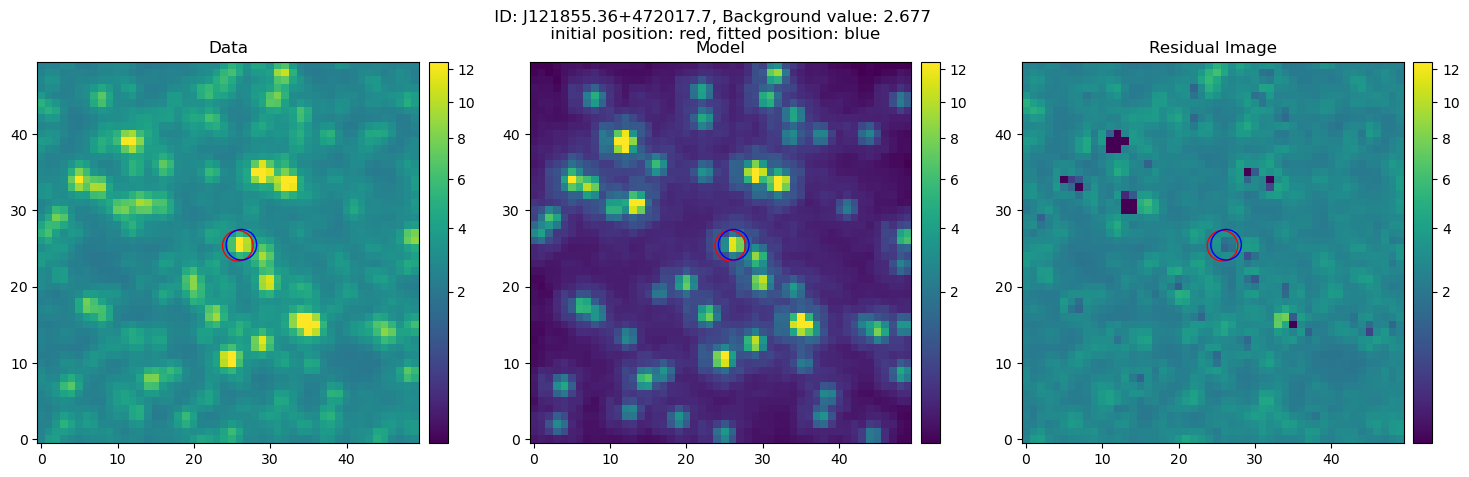

In [13]:
photometry.plot_residuals()

### Phase corr
### crowding
### reddenning
